Theoretical Exploration for guided brushing project
---
_Note:_ This is mostly stream of thought coding and becasue of this there is a decent amount of meh code and duplicated things.
- _If you have any questions because of this reach out to rpechuk@gmail.com and I can clarify_
---
Link to notes: https://docs.google.com/document/d/1wa2a7imNCCCAmzHUXC524VPUQRlfMAmVt0bnOmlcQog/edit?usp=sharing

### Imports

In [2]:
import numpy as np
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize, SymLogNorm, AsinhNorm
import seaborn as sns
import tqdm
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Offline Data Creation - Crossfilter Example

In [55]:
df = pd.read_parquet('./data/flights-200k.parquet')

In [56]:
query_select_delay_time = """
SELECT
    (1.0 * FLOOR(time / 1.0))::INT AS x1,
    (1.0 * (1 + FLOOR(time / 1.0)))::INT AS x2,
    COUNT(*)::INT AS y,
    FLOOR(2.32 * (delay - -60))::INT AS active0
FROM df
GROUP BY x1, x2, active0
ORDER BY x1, x2, active0
"""

query_select_delay_distance = """
SELECT
    100 + 100::DOUBLE * (FLOOR(("distance" - 100) / 100::DOUBLE)) AS "x1",
    100 + 100::DOUBLE * (1 + FLOOR(("distance" - 100) / 100::DOUBLE)) AS "x2",
    COUNT(*)::INTEGER AS "y",
     FLOOR(2.16::DOUBLE * ("delay" - -60::DOUBLE))::INTEGER AS "active0"
FROM df
GROUP BY "x1", "x2", "active0"
ORDER BY "x1", "x2", "active0"
"""

query_select_time_delay = """
SELECT
    (-60 + 10 * FLOOR((delay - -60) / 10))::INT AS x1,
    (-60 + 10 * (1 + FLOOR((delay - -60) / 10)))::INT AS x2,
    (COUNT(*))::INT AS y,
    (FLOOR(24.166666666666668 * (time - 0)))::INT AS active0
FROM df
GROUP BY x1, x2, active0
ORDER BY x1, x2, active0
"""

query_select_time_distance = """
SELECT
    100 + 100::DOUBLE * (FLOOR(("distance" - 100) / 100::DOUBLE)) AS "x1",
    100 + 100::DOUBLE * (1 + FLOOR(("distance" - 100) / 100::DOUBLE)) AS "x2",
    COUNT(*)::INTEGER AS "y",
    FLOOR(22.5::DOUBLE * ("time" - 0::DOUBLE))::INTEGER AS "active0"
FROM df
GROUP BY "x1", "x2", "active0"
ORDER BY "x1", "x2", "active0"
"""

query_select_distance_delay = """
SELECT
    -60 + 10::DOUBLE * (FLOOR(("delay" - -60) / 10::DOUBLE)) AS "x1",
    -60 + 10::DOUBLE * (1 + FLOOR(("delay" - -60) / 10::DOUBLE)) AS "x2",
    COUNT(*)::INTEGER AS "y",
    FLOOR(0.24545454545454545::DOUBLE * ("distance" - 100::DOUBLE))::INTEGER AS "active0"
FROM df
GROUP BY "x1", "x2", "active0"
ORDER BY "x1", "x2", "active0"
"""

query_select_distance_time = """
SELECT
    0 + 1::DOUBLE * (FLOOR("time" / 1::DOUBLE)) AS "x1",
    0 + 1::DOUBLE * (1 + FLOOR("time" / 1::DOUBLE)) AS "x2",
    COUNT(*)::INTEGER AS "y",
    FLOOR(0.24545454545454545::DOUBLE * ("distance" - 100::DOUBLE))::INTEGER AS "active0"
FROM df
GROUP BY "x1", "x2", "active0"
ORDER BY "x1", "x2", "active0"
"""

In [57]:
# Execute the query using DuckDB
# The resulting schema:
# - x1, x2 -> bin start, bin end for time histogram (note that x2 is simply an offset from x1 used for plotting)
# - y -> count of records per data cube cell
# - active0 -> pixel bins in the active view
data_cube_delay_time = duckdb.query(query_select_delay_time).df()
data_cube_delay_distance = duckdb.query(query_select_delay_distance).df()
data_cube_time_delay = duckdb.query(query_select_time_delay).df()
data_cube_time_distance = duckdb.query(query_select_time_distance).df()
data_cube_distance_delay = duckdb.query(query_select_distance_delay).df()
data_cube_distance_time = duckdb.query(query_select_distance_time).df()

### Metrics

In [3]:
def L1_norm(base_data, scrubbed_vals):
    return np.sum(np.abs(base_data['y'] - scrubbed_vals['y']))

def L2_norm(base_data, scrubbed_vals):
    return np.sum((base_data['y'] - scrubbed_vals['y']) ** 2)

def KL_divergence(base_data, scrubbed_vals):
    return np.sum(base_data['y'] * np.log(base_data['y'] / scrubbed_vals['y']))

def EMD(base_data, scrubbed_vals):
    return np.sum(np.abs(np.cumsum(base_data['y']) - np.cumsum(scrubbed_vals['y'])))

def KS_test(base_data, scrubbed_vals):
    return np.max(np.abs(np.cumsum(base_data['y']) - np.cumsum(scrubbed_vals['y'])))

In [4]:
# Summary statistics (Within the active view instead of comparing active views). Entropy, mean, median, sd, ...
def entropy(data):
    p = data.groupby('x1').apply(lambda x: np.sum(x['y']) / np.sum(data['y'])).values
    return -np.sum(p * np.log(p))

def mean(data):
    return np.sum(data['y'] * data['x1']) / np.sum(data['y'])

def median(data):
    sorted_data = data.sort_values('x1')
    x1 = sorted_data['x1'].values
    y = sorted_data['y'].values
    cumsum = np.cumsum(y)
    # handle case where median is in between two bins
    if np.sum(data['y']) % 2 == 0:
        return (x1[np.argmax(cumsum > np.sum(data['y']) / 2)] + x1[np.argmax(cumsum > np.sum(data['y']) / 2) - 1]) / 2
    else:
        return x1[np.argmax(cumsum > np.sum(data['y']) / 2)]

def sd(data):
    return np.sqrt(np.sum(data['y'] * (data['x1'] - mean(data))**2) / np.sum(data['y']))

### Sliding window - wider exploration

In [5]:
def get_base_data(data_cube: pd.DataFrame):
    # base_query = f'SELECT "x1", "x2", SUM("y") AS "y" FROM "{data_cube_name}" GROUP BY "x1", "x2" ORDER BY "x1", "x2"'
    # base_vals = duckdb.query(base_query).df()
    base_vals = data_cube.groupby(['x1', 'x2']).sum().reset_index()
    return base_vals

def get_scrubbed_data_active0(data_cube: pd.DataFrame, L: int, R: int):
    # scrub_query = f'SELECT "x1", "x2", SUM("y") AS "y" FROM "{data_cube_name}" WHERE "active0" >= {L} AND "active0" <= {R} GROUP BY "x1", "x2" ORDER BY "x1", "x2"'
    # scrubbed_vals = duckdb.query(scrub_query).df()
    scrubbed_vals = data_cube.loc[(data_cube['active0'] >= L) & (data_cube['active0'] <= R), :].groupby(['x1', 'x2']).sum().reset_index()
    return scrubbed_vals

def search_data_cube_window_active0(data_cube, statistic, window_size=10, strict=True, optimization=0):
    # Get the active0 range by getting the min and max values
    active0_range = data_cube['active0'].unique()
    active0_range.sort()
    min_active0 = int(active0_range[0])
    max_active0 = int(active0_range[-1])
    window = int((max_active0 - min_active0) * (window_size / 100))
    jump = window // optimization if optimization > 0 else 1
    if strict:
        return np.array([statistic(get_scrubbed_data_active0(data_cube, i, i + window))
                            for i in range(min_active0, max_active0 - window, jump)])
    else:
        # Return 2D array of the statistics where the first index is the start of the window and the second index is the end of the window
        stats = np.zeros((max_active0 - min_active0, max_active0 - min_active0))
        stats.fill(np.nan)
        for i in tqdm.tqdm(range(min_active0, max_active0 - window, jump)):
            for j in range(i + window, max_active0, jump):
                stats[i - min_active0, j - min_active0] = statistic(get_scrubbed_data_active0(data_cube, i, j))
        return stats


def get_scrubbed_data_by_value(data_cube: pd.DataFrame, L: int, R: int):
    scrubbed_vals = data_cube.loc[(data_cube['x1'] >= L) & (data_cube['x1'] <= R), :].groupby(['x1', 'x2']).sum().reset_index()
    return scrubbed_vals


def search_data_cube_window_by_value(data_cube, statistic, window_size=10, strict=True, optimization=0):
    # Get the active0 range by getting the min and max values
    x1_range = data_cube['x1'].unique()
    x1_range.sort()
    min_x1 = int(x1_range[0])
    max_x1 = int(x1_range[-1])
    window = int((max_x1 - min_x1) * (window_size / 100))
    jump = window // optimization if optimization > 0 else 1
    if strict:
        return np.array([statistic(get_scrubbed_data_by_value(data_cube, i, i + window))
                            for i in range(min_x1, max_x1 - window, jump)])
    else:
        # Return 2D array of the statistics where the first index is the start of the window and the second index is the end of the window
        stats = np.zeros((max_x1 - min_x1, max_x1 - min_x1))
        stats.fill(np.nan)
        for i in tqdm.tqdm(range(min_x1, max_x1 - window, jump)):
            for j in range(i + window, max_x1, jump):
                stats[i - min_x1, j - min_x1] = statistic(get_scrubbed_data_by_value(data_cube, i, j))
        return stats

    
def find_interesting(stats: np.ndarray, window_size=10, tolerance=0.05):
    # Get the indices of the minimum and maximum values and find a window where the stats are within tolerance (%)
    # of the min and max and call these the two windows. Don't forget to add window size to the higher index to get the end of the window
    assert len(stats.shape) == 1, "Stats must be a 1D array"
    min_idx = int(np.argmin(stats))
    max_idx = int(np.argmax(stats))
    min_val = stats[min_idx]
    max_val = stats[max_idx]
    window = int((window_size / 100) * len(stats) / (1 - (window_size / 100)))
    # Find the window where the stats are within tolerance of the min and max
    min_window = (min_idx, min_idx + window)
    max_window = (max_idx, max_idx + window)
    # for i in range(min_idx + window, len(stats)):
    #     if stats[i] > min_val * (1 + tolerance):
    #         min_window = (min_idx, i + window)
    #         break
    # for i in range(max_idx + window, len(stats)):
    #     if stats[i] < max_val * (1 - tolerance):
    #         max_window = (max_idx, i + window)
    #         break
    return min_window, max_window

def plot(data_cube: pd.DataFrame, selected_window: tuple[int, int]):
    base_data = get_base_data(data_cube)
    scrubbed_data = get_scrubbed_data_active0(data_cube, selected_window[0], selected_window[1])
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].bar(base_data['x1'], base_data['y'], width=1, align='edge', edgecolor='black')
    ax[1].bar(scrubbed_data['x1'], scrubbed_data['y'], width=1, align='edge', edgecolor='black')
    ax[0].set_title('Base Data')
    ax[1].set_title('Selected Data')
    plt.show()

# Do the exact same thing as above but with any number of selected windows
def plot_many(data: pd.DataFrame, data_cube: pd.DataFrame, selected_windows: list[tuple[int, int]], brushed='variable_0', sharex=True, sharey=False):
    base_data = get_base_data(data_cube)
    fig, ax = plt.subplots(len(selected_windows), 1, figsize=(10, 10), sharex=sharex, sharey=sharey)

    def to_x(x):
        return x + data[brushed].min()

    # Base data plot
    base_width = np.min(np.diff(np.sort(base_data['x1'])))

    # Plots for each window
    for i, window in enumerate(selected_windows):
        ax2 = ax[i].twinx()  # Create a secondary y-axis
        
        # Plot base data on secondary y-axis
        ax2.bar(base_data['x1'], base_data['y'], width=base_width, align='edge', edgecolor='black', alpha=0.1, color='red')
        ax2.set_ylabel('Base Data', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Plot scrubbed data on primary y-axis
        scrubbed_data = get_scrubbed_data_active0(data_cube, window[0], window[1])
        ax[i].bar(scrubbed_data['x1'], scrubbed_data['y'], width=base_width, align='edge', edgecolor='black')
        ax[i].set_title(f'Window {i}: Selected Data {to_x(window[0])} - {to_x(window[1])}')
        ax[i].set_ylabel('Scrubbed Data')
    # plt.show()

    colors = ['blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
    inset_ax = fig.add_axes([0.75, 0.75, 0.1, 0.1])
    inset_ax.bar(data[brushed].unique(), data[brushed].value_counts(), width=1, align='edge', edgecolor='black', alpha=0.1, color='red')
    for i, window in enumerate(selected_windows):
        inset_ax.axvline(to_x(window[0]), color=colors[i % len(colors)], linestyle='--')
        inset_ax.axvline(to_x(window[1]), color=colors[i % len(colors)], linestyle='--')
        inset_ax.text(to_x((window[0] + window[1]) / 2), data[brushed].value_counts().max() * 1.1, f'Window {i}', color=colors[i % len(colors)], horizontalalignment='center', fontsize=7)
    plt.show()

#### Pairwise searching

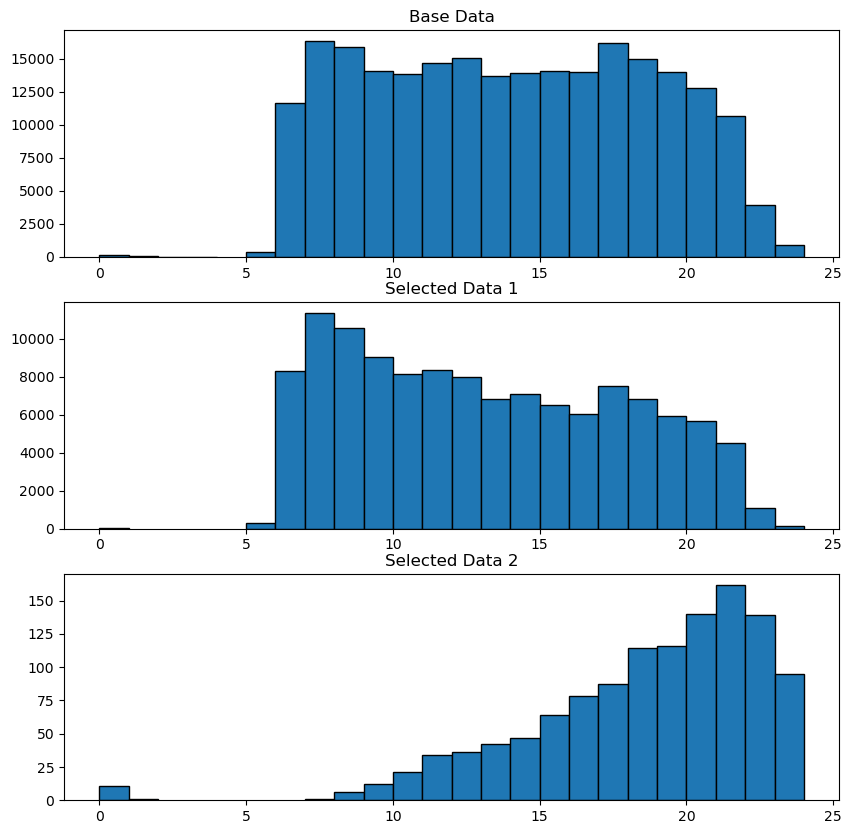

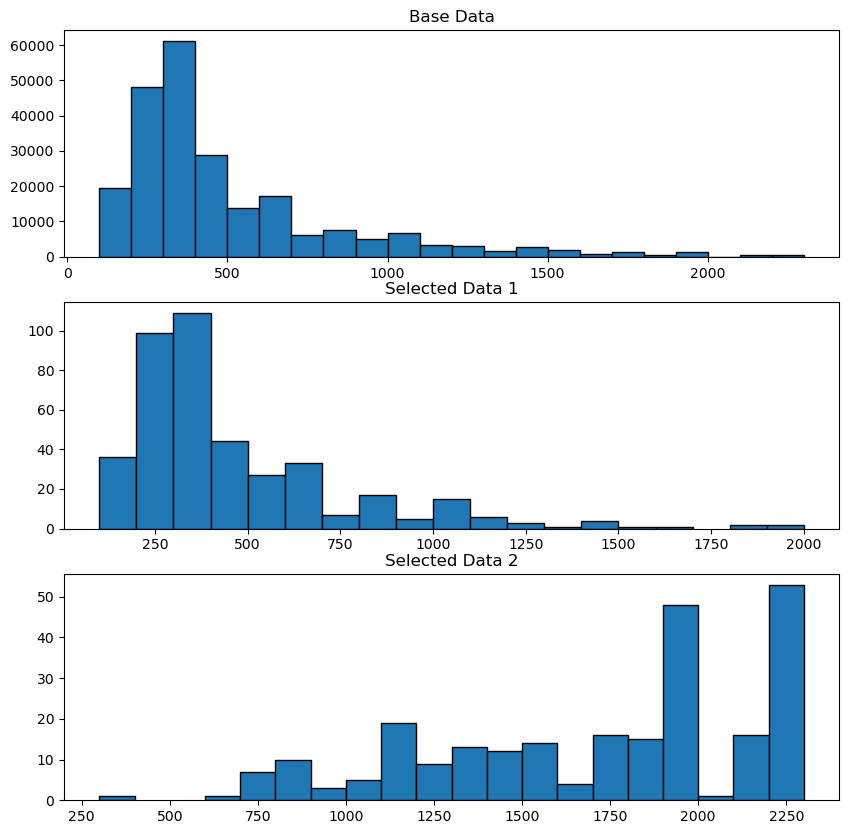

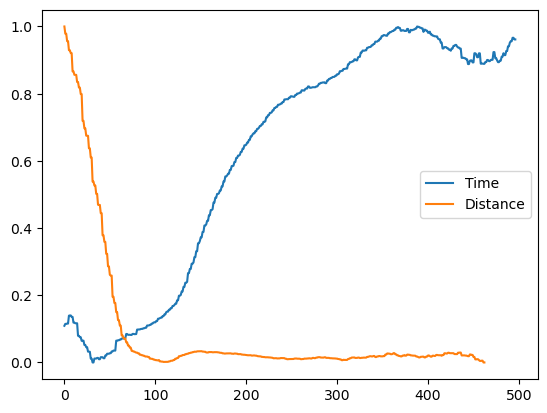

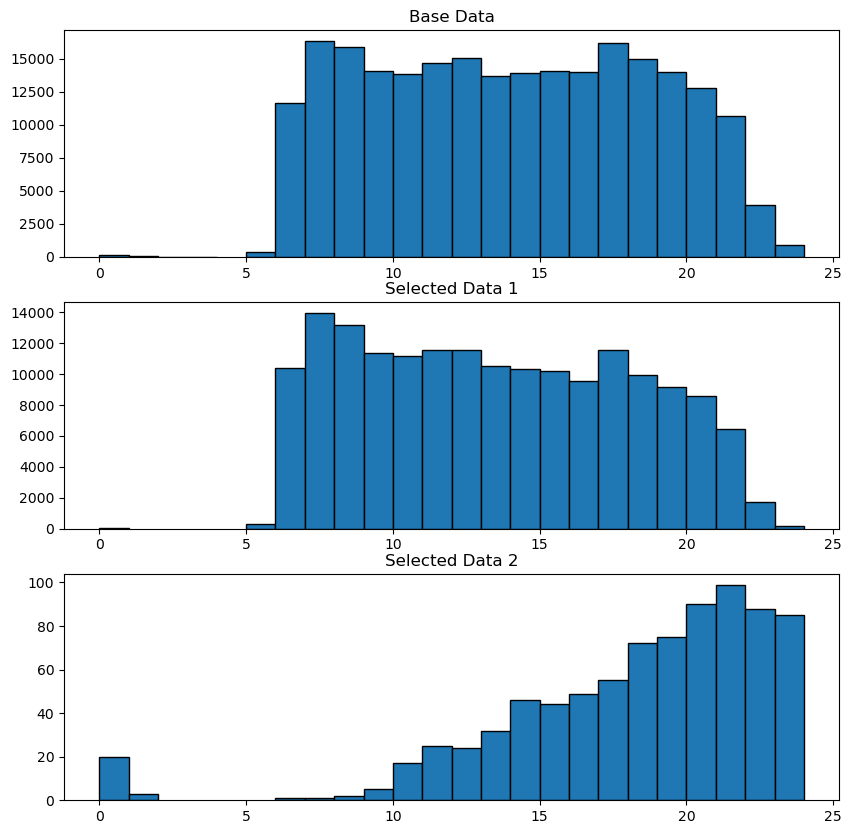

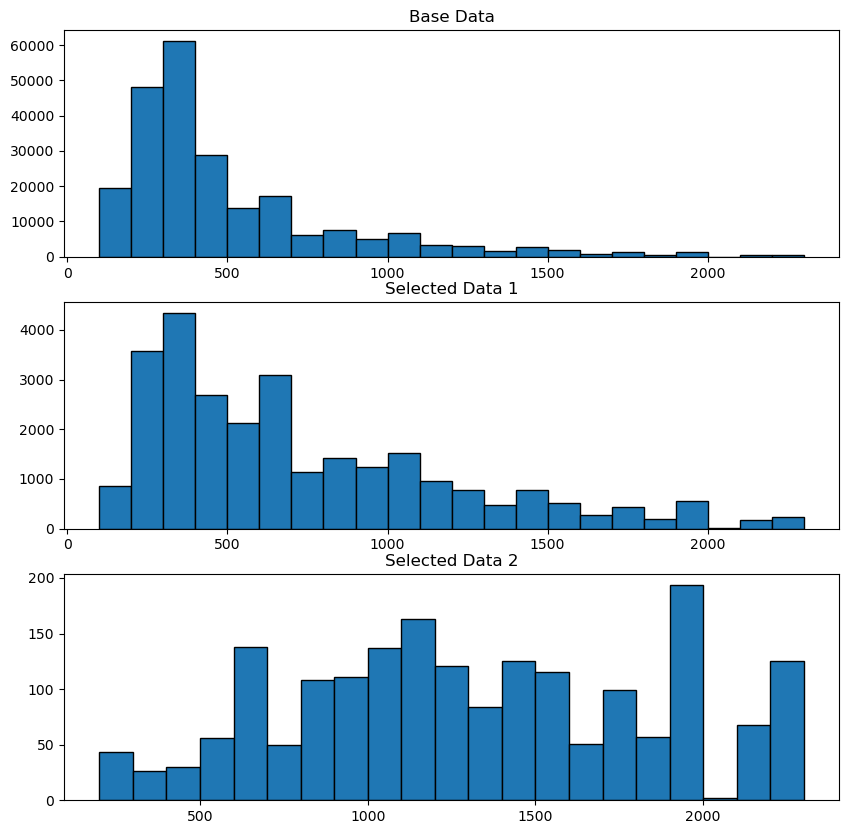

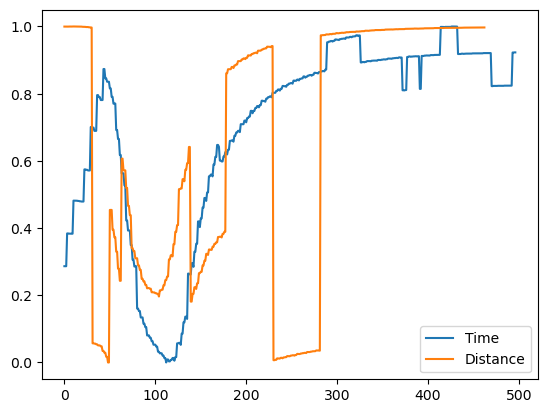

In [17]:
stats_time = search_data_cube_window_active0(data_cube_delay_time, mean, window_size=10)
min_window, max_window = find_interesting(stats_time, window_size=10)
plot_many(data_cube_delay_time, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_delay_distance, mean, window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_delay_distance, [min_window, max_window])
# Plot the statistics on the same line chart
stats_time = (stats_time - np.min(stats_time)) / (np.max(stats_time) - np.min(stats_time))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_time, label='Time')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()
stats_time = search_data_cube_window_active0(data_cube_delay_time, lambda x: L2_norm(get_base_data(data_cube_delay_time), x), window_size=10)
min_window, max_window = find_interesting(stats_time, window_size=10)
plot_many(data_cube_delay_time, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_delay_distance, lambda x: L2_norm(get_base_data(data_cube_delay_distance), x), window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_delay_distance, [min_window, max_window])
# Plot the statistics on the same line chart
stats_time = (stats_time - np.min(stats_time)) / (np.max(stats_time) - np.min(stats_time))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_time, label='Time')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()

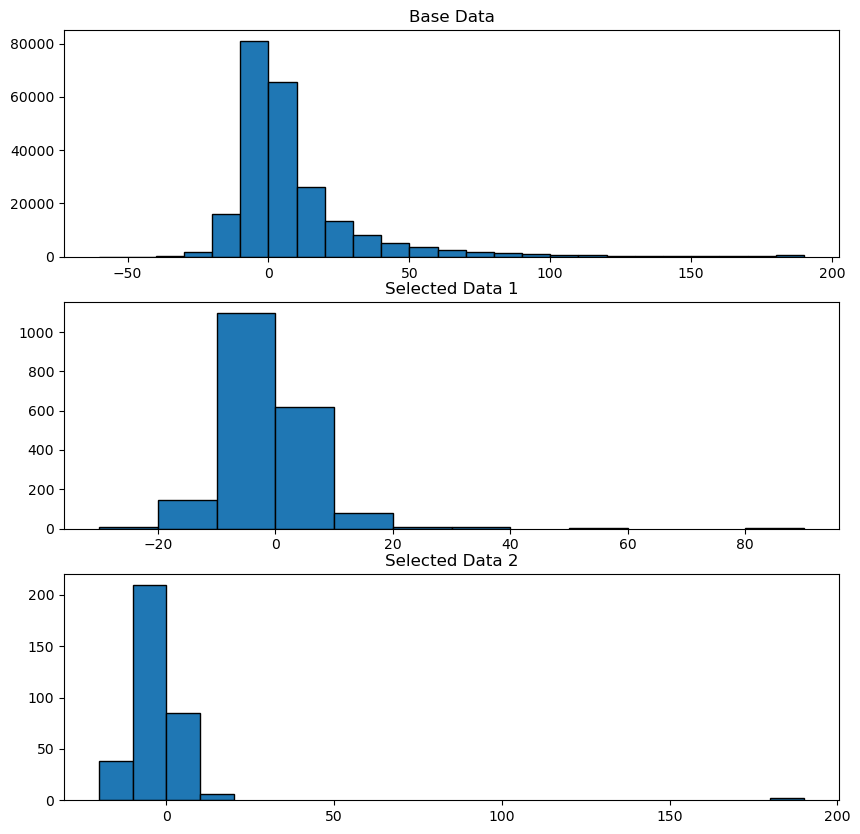

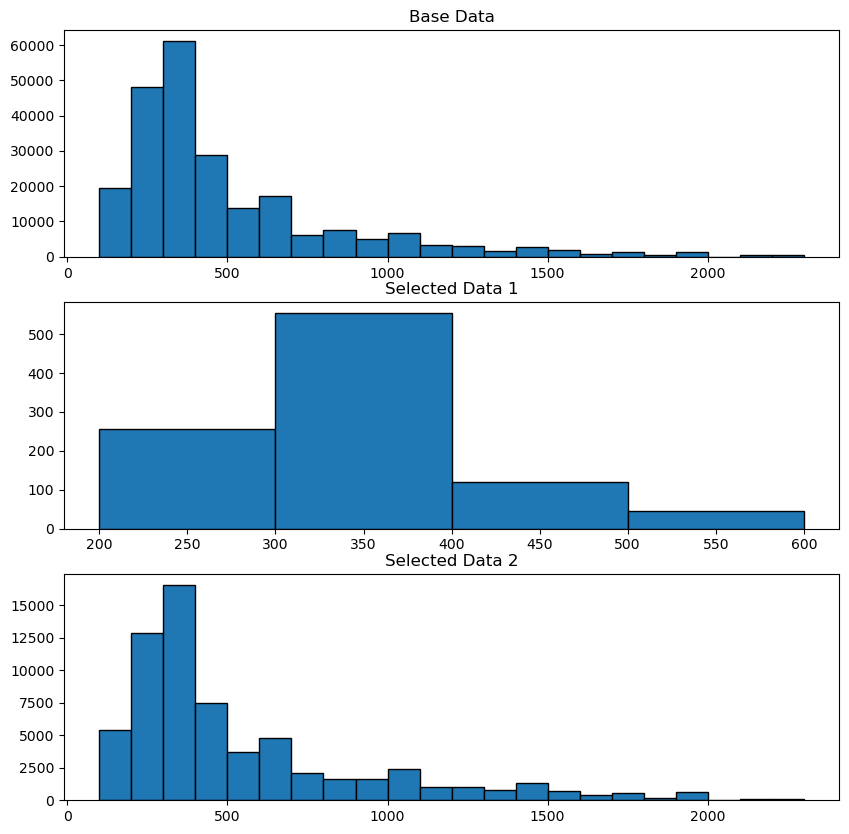

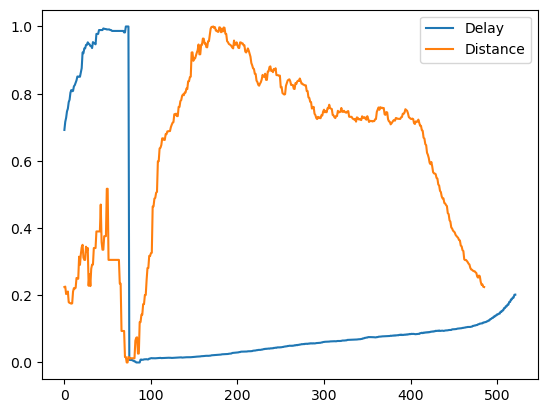

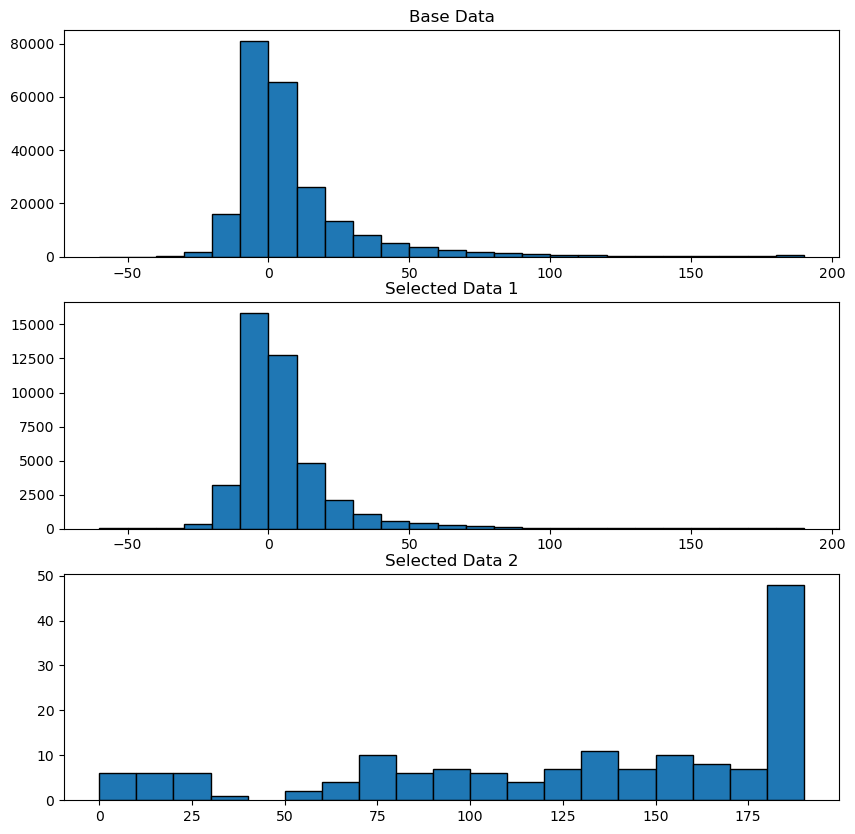

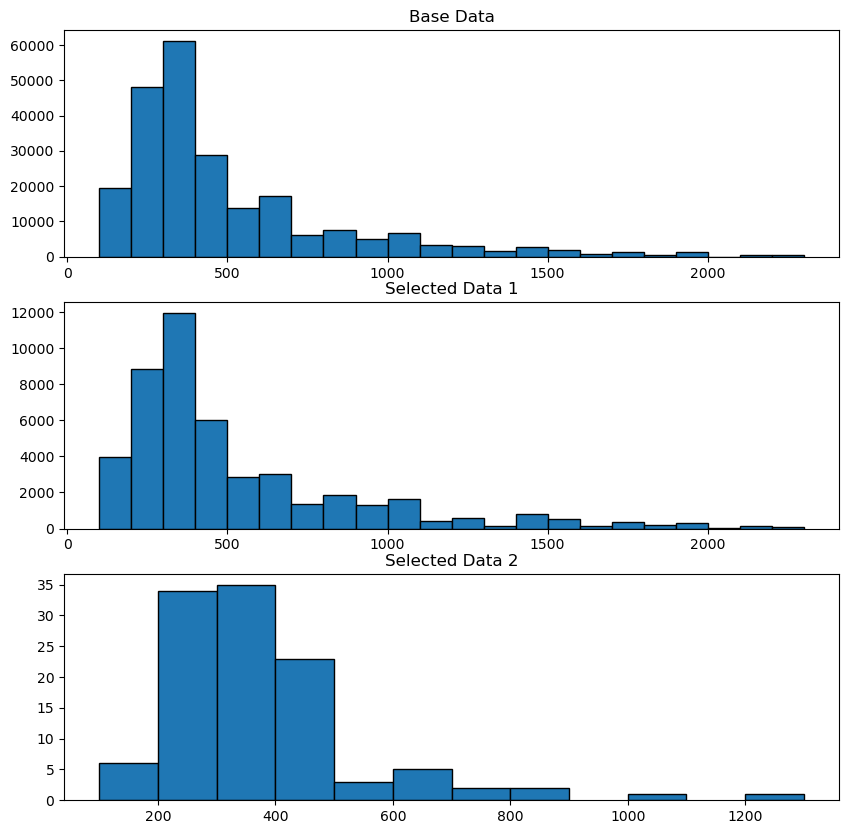

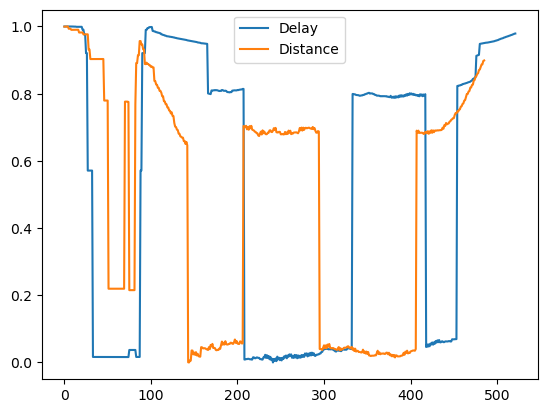

In [18]:
stats_delay = search_data_cube_window_active0(data_cube_time_delay, mean, window_size=10)
min_window, max_window = find_interesting(stats_delay, window_size=10)
plot_many(data_cube_time_delay, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_time_distance, mean, window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_time_distance, [min_window, max_window])
# Plot the statistics on the same line chart
stats_delay = (stats_delay - np.min(stats_delay)) / (np.max(stats_delay) - np.min(stats_delay))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_delay, label='Delay')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()
stats_delay = search_data_cube_window_active0(data_cube_time_delay, lambda x: L2_norm(get_base_data(data_cube_time_delay), x), window_size=10)
min_window, max_window = find_interesting(stats_delay, window_size=10)
plot_many(data_cube_time_delay, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_time_distance, lambda x: L2_norm(get_base_data(data_cube_time_distance), x), window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_time_distance, [min_window, max_window])
# Plot the statistics on the same line chart
stats_delay = (stats_delay - np.min(stats_delay)) / (np.max(stats_delay) - np.min(stats_delay))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_delay, label='Delay')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()

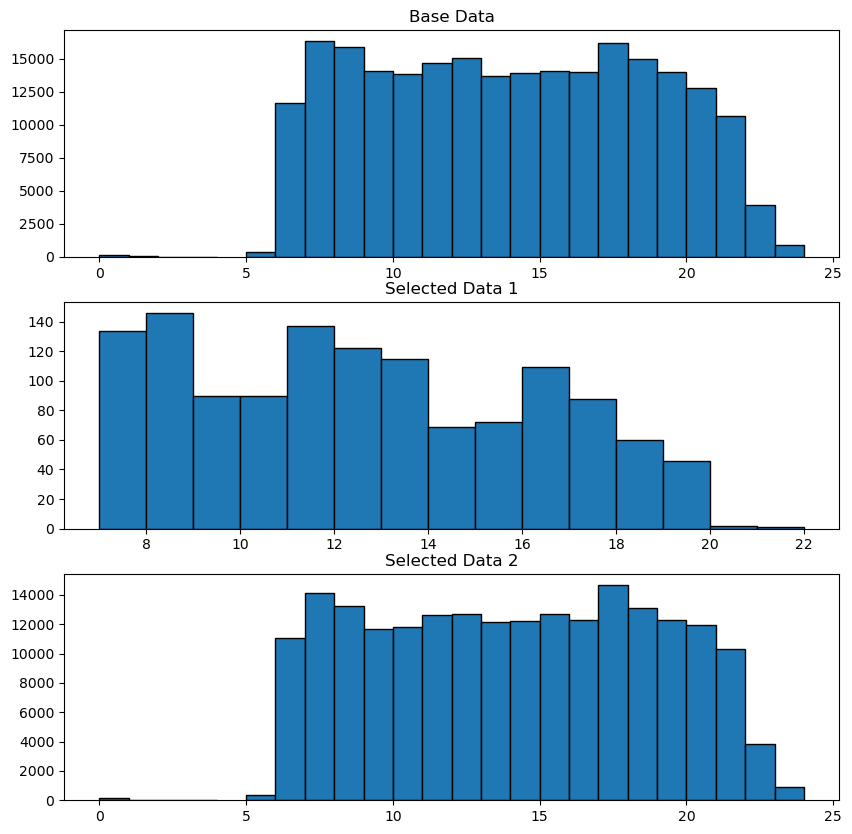

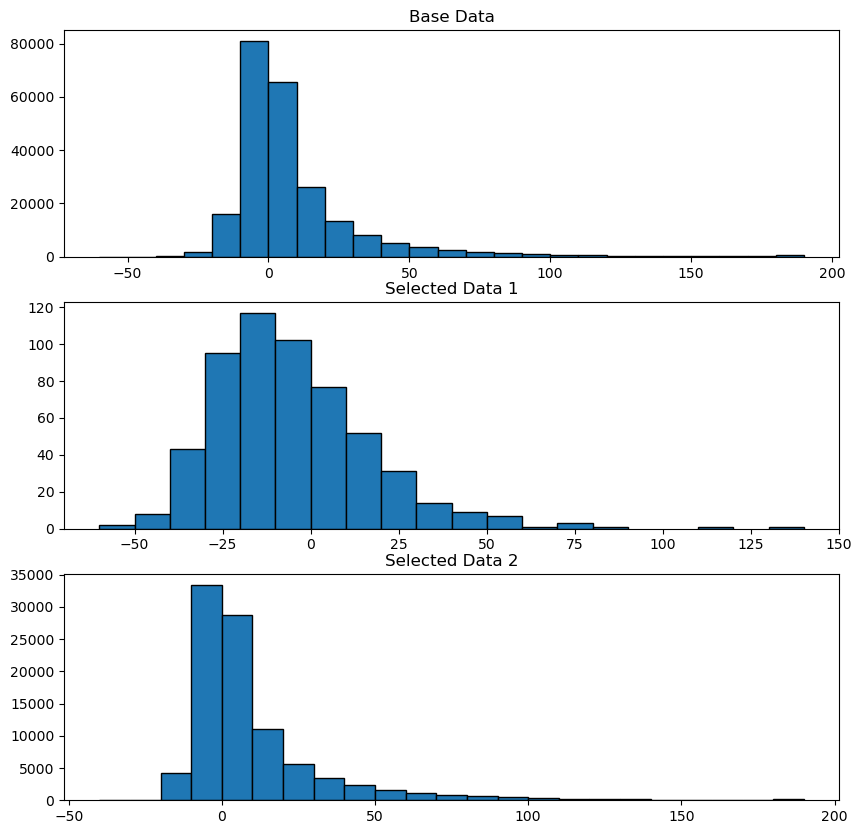

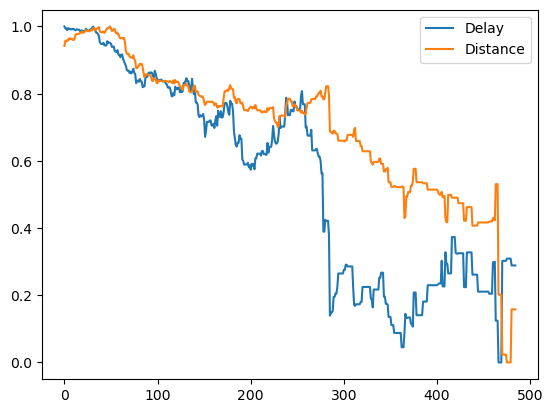

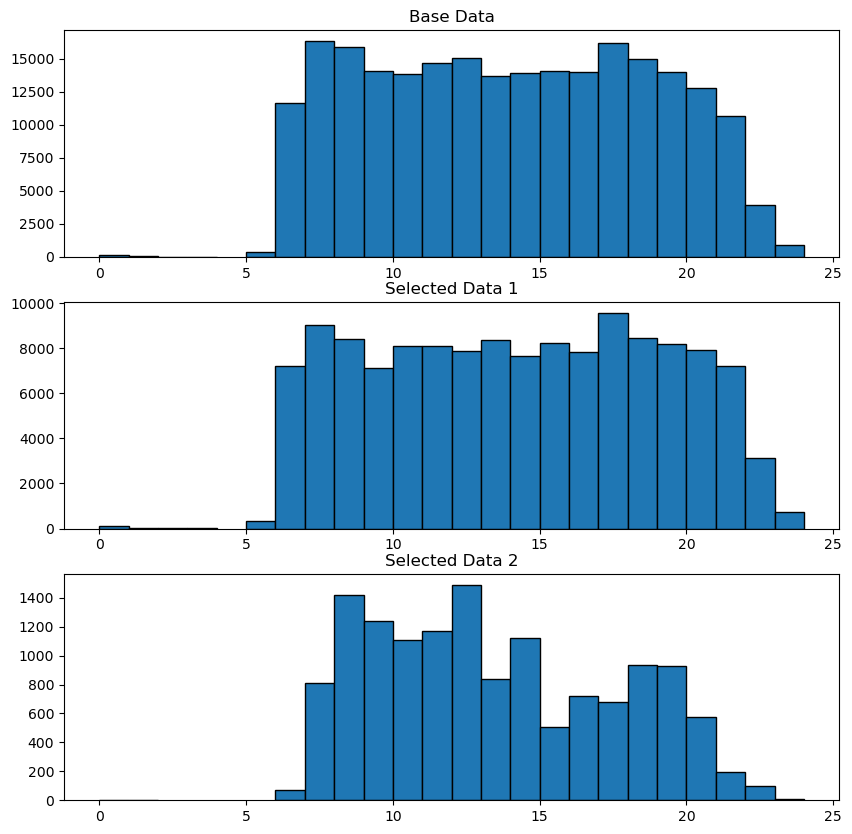

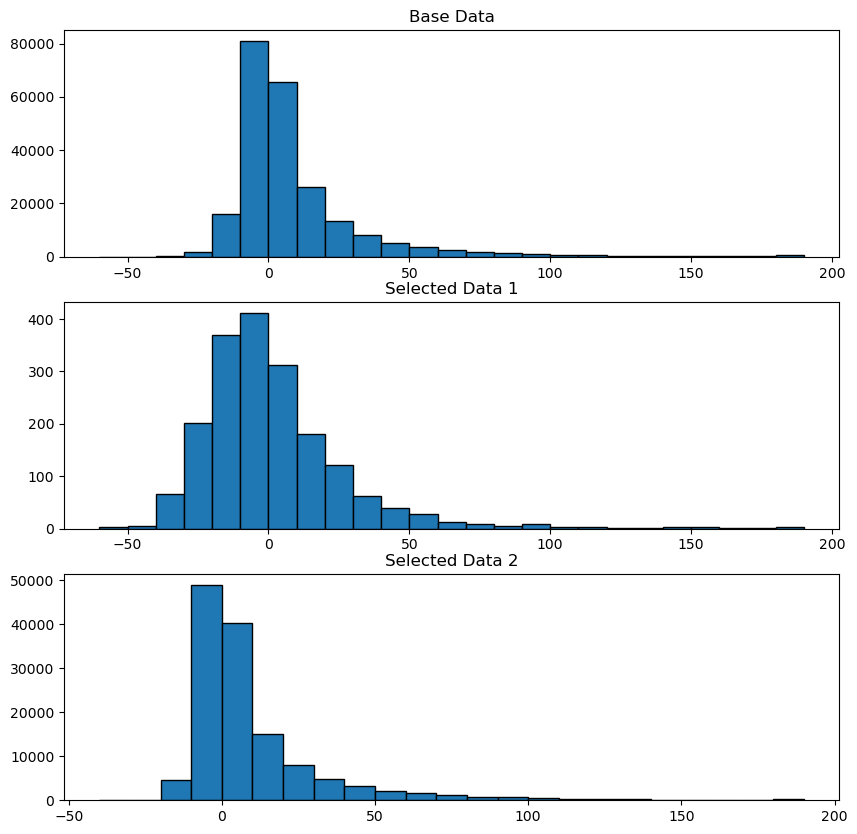

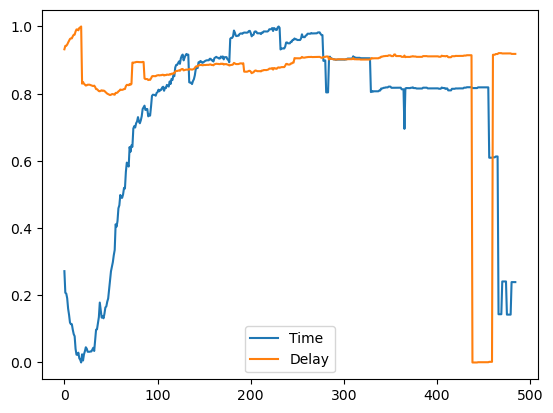

In [19]:
stats_time = search_data_cube_window_active0(data_cube_distance_time, mean, window_size=10)
min_window, max_window = find_interesting(stats_time, window_size=10)
plot_many(data_cube_distance_time, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_distance_delay, mean, window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_distance_delay, [min_window, max_window])
# Plot the statistics on the same line chart
stats_time = (stats_time - np.min(stats_time)) / (np.max(stats_time) - np.min(stats_time))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_time, label='Delay')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()
stats_time = search_data_cube_window_active0(data_cube_distance_time, lambda x: L2_norm(get_base_data(data_cube_distance_time), x), window_size=10)
min_window, max_window = find_interesting(stats_time, window_size=10)
plot_many(data_cube_distance_time, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_distance_delay, lambda x: L2_norm(get_base_data(data_cube_distance_delay), x), window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_distance_delay, [min_window, max_window])
# Plot the statistics on the same line chart
stats_time = (stats_time - np.min(stats_time)) / (np.max(stats_time) - np.min(stats_time))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_time, label='Time')
plt.plot(stats_distance, label='Delay')
plt.legend()
plt.show()

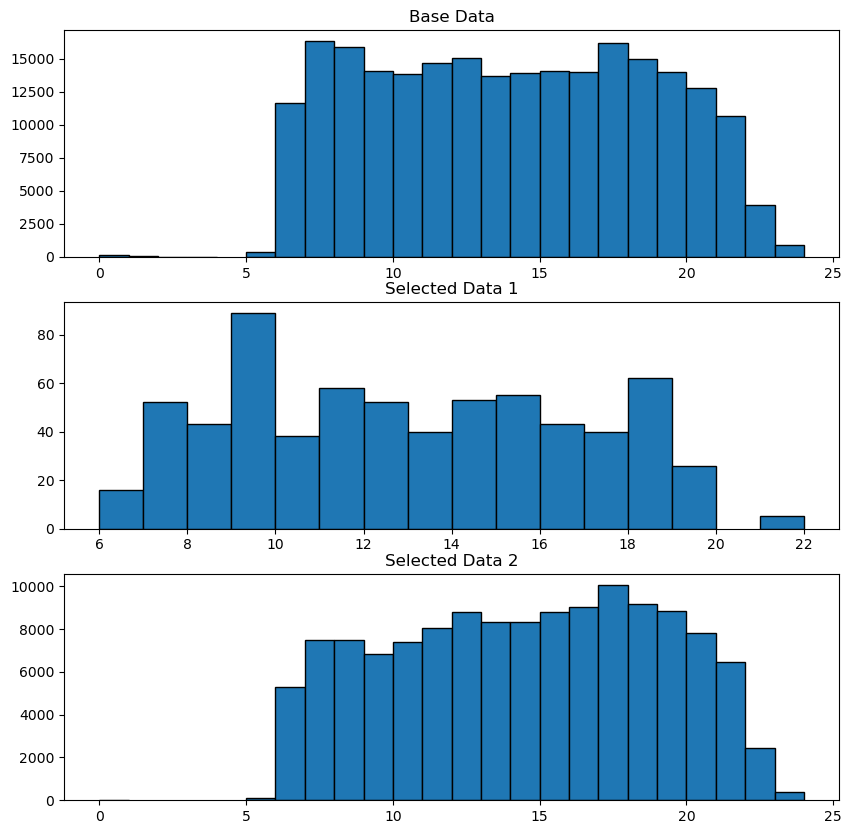

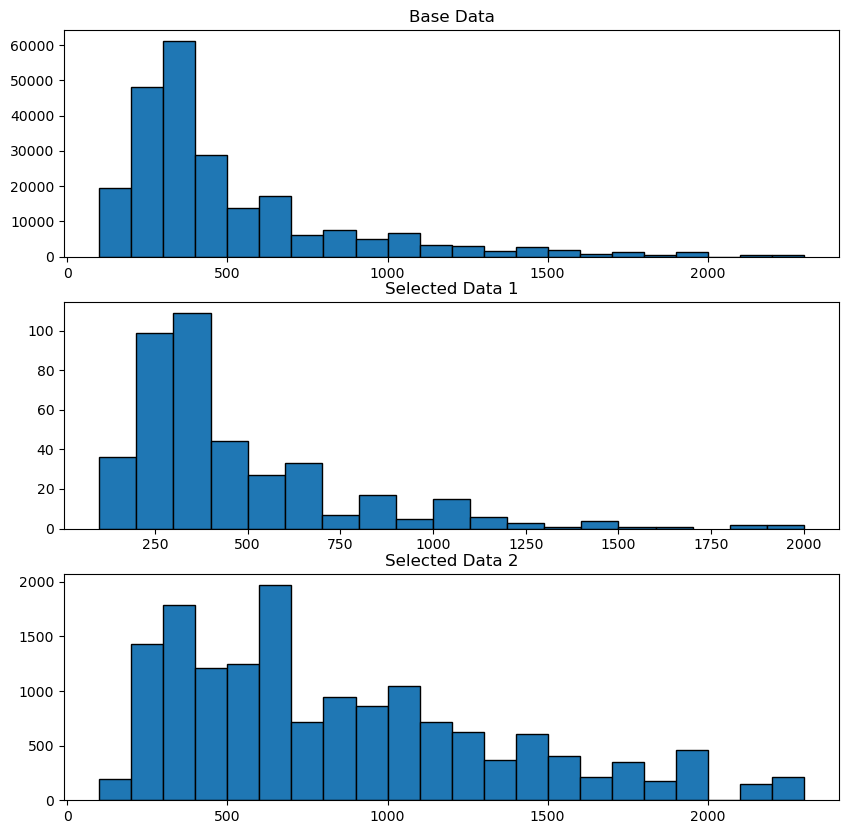

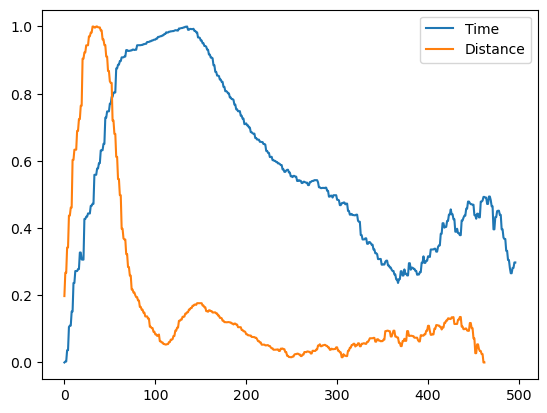

In [20]:
stats_time = search_data_cube_window_active0(data_cube_delay_time, entropy, window_size=10)
min_window, max_window = find_interesting(stats_time, window_size=10)
plot_many(data_cube_delay_time, [min_window, max_window])
stats_distance = search_data_cube_window_active0(data_cube_delay_distance, entropy, window_size=10)
min_window, max_window = find_interesting(stats_distance, window_size=10)
plot_many(data_cube_delay_distance, [min_window, max_window])
# Plot the statistics on the same line chart
stats_time = (stats_time - np.min(stats_time)) / (np.max(stats_time) - np.min(stats_time))
stats_distance = (stats_distance - np.min(stats_distance)) / (np.max(stats_distance) - np.min(stats_distance))
plt.plot(stats_time, label='Time')
plt.plot(stats_distance, label='Distance')
plt.legend()
plt.show()

#### data gen and POC testing for sliding window approach

In [6]:
def generate_data(
    causal_matrix,
    num_samples,
    noise_func=np.random.standard_normal,
    round=0
):
    num_variables = causal_matrix.shape[0]
    data_cube = np.zeros((num_samples, num_variables))
    
    for i in range(num_variables):
        # See if this is a base variable or a dependent variable
        if causal_matrix[i, i] != 0: # This is a base variable
            data_cube[:, i] = np.round(causal_matrix[i, i](num_samples), round)
        else: # This is a dependent variable
            # Get all the variables that this variable depends on
            dependencies = np.where(causal_matrix[:, i] != 0)[0]
            # Get the functions that this variable depends on
            functions = causal_matrix[dependencies, i]
            # Get the data for the dependencies
            dependency_data = data_cube[:, dependencies]
            # Calculate the dependent variable
            for j in range(num_samples):
                data_cube[j, i] = np.round(np.sum([functions[k](dependency_data[j, k]) for k in range(len(dependencies))]) + noise_func(), round)
    
    # Create DataFrame with variable names as columns
    column_names = [f"variable_{i}" for i in range(num_variables)]
    df = pd.DataFrame(data_cube, columns=column_names)

    return df

def plot_distributions(data):
    num_variables = data.shape[1]
    fig, ax = plt.subplots(num_variables, 1, figsize=(10, 5), sharex=True)
    
    for i in range(num_variables):
        ax[i].hist(data.iloc[:, i], bins=50, color='blue', edgecolor='black', alpha=0.7)
        ax[i].set_title(f"Variable {i}")
    
    plt.tight_layout()
    plt.show()

In [414]:
def window_to_active0(window, data):
    return (int(window[0] - data['variable_0'].min()), int(window[1] - data['variable_0'].min()))

In [9]:
def e2e(
    causal_matrix,
    num_samples,
    noise_func=np.random.standard_normal,
    round=0,
    brush='variable_0',
    dependent='variable_1',
):
    # Generate data
    data = generate_data(causal_matrix, num_samples, noise_func, round)
    plot_distributions(data)
    dc_query = f"""
    SELECT
        "{dependent}" AS "x1",
        "{dependent}" AS "x2",
        COUNT(*) AS "y",
        FLOOR("{brush}" - {data[brush].min()})::INT AS "active0"
    FROM data
    GROUP BY "x1", "x2", "active0"
    ORDER BY "x1", "x2", "active0"
    """
    data_cube = duckdb.query(dc_query).df()
    # Get statistics for the data cube and plot
    mean_stat = search_data_cube_window_active0(data_cube, mean, window_size=20)
    min_window, max_window = find_interesting(mean_stat, window_size=20)
    plot_many(data, data_cube, [min_window, max_window], brushed=brush)
    entropy_stat = search_data_cube_window_active0(data_cube, entropy, window_size=20)
    min_window, max_window = find_interesting(entropy_stat, window_size=20)
    plot_many(data, data_cube, [min_window, max_window], brushed=brush)
    for i in range(1, len(entropy_stat)):
        plt.plot([entropy_stat[i - 1], entropy_stat[i]], [mean_stat[i - 1], mean_stat[i]], c=sns.cm.flare(i / len(entropy_stat)))
    plt.scatter(entropy_stat, mean_stat, c=range(len(entropy_stat)), cmap='flare')
    plt.title('Entropy vs Mean')
    plt.xlabel('Entropy')
    plt.ylabel('Mean')
    plt.colorbar()
    plt.show()

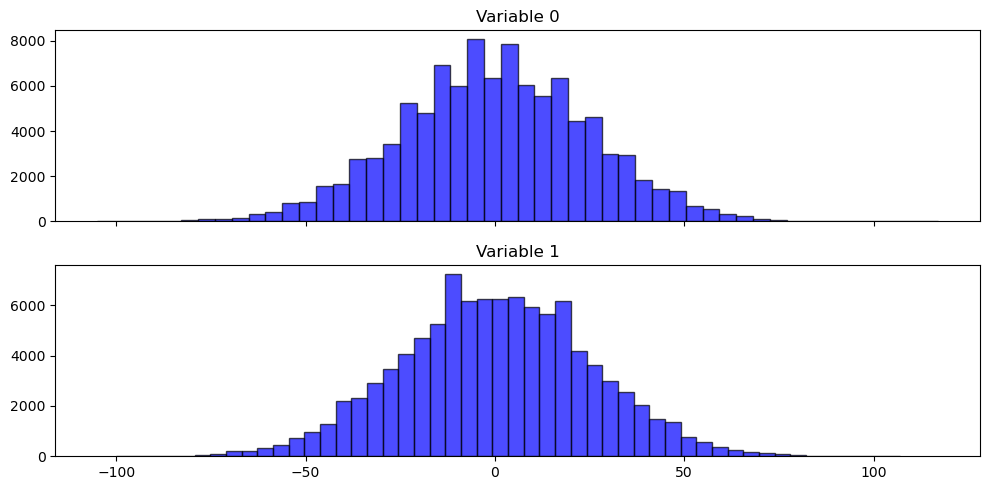

1.0
Window 0 took 0.1425309181213379 seconds
Window 1 took 0.2973778247833252 seconds


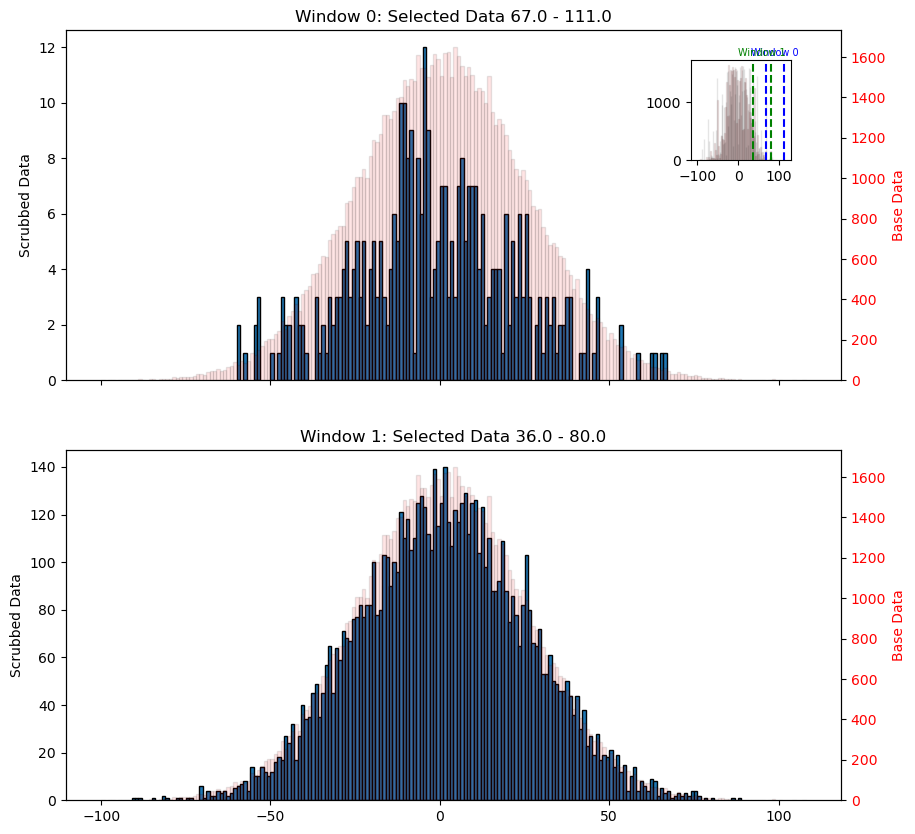

1.0
Window 0 took 0.12394189834594727 seconds
Window 1 took 0.1689891815185547 seconds


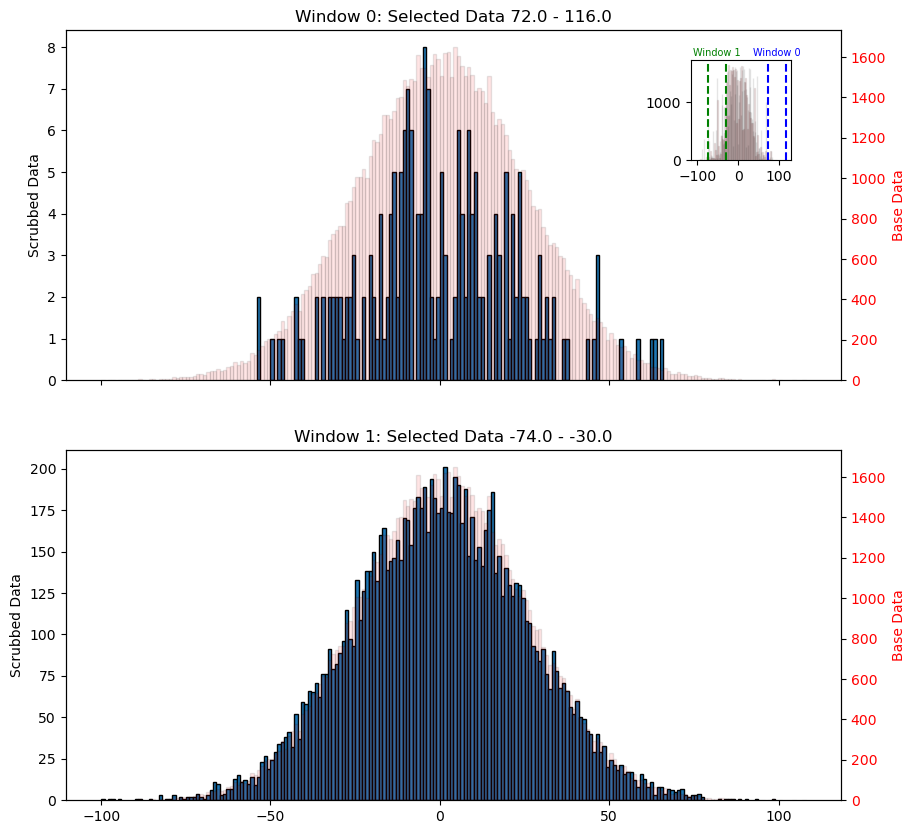

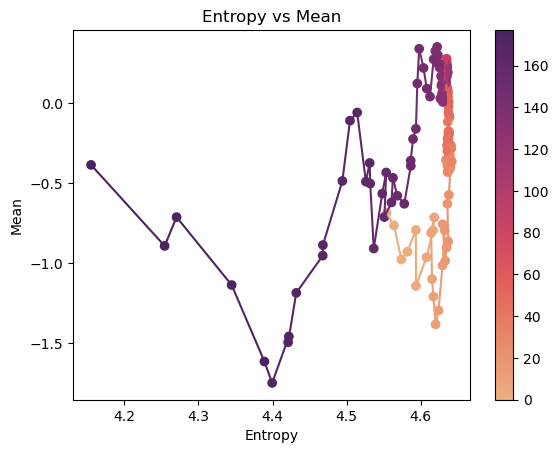

In [28]:
# Define simple causal matrix with two unrelated variables
causal_matrix = np.array([
    [lambda x: np.random.normal(0, 25, size=x), 0],
    [0, lambda x: np.random.normal(0, 25, size=x)]
])

e2e(causal_matrix, 100000, round=0, brush='variable_0', dependent='variable_1')

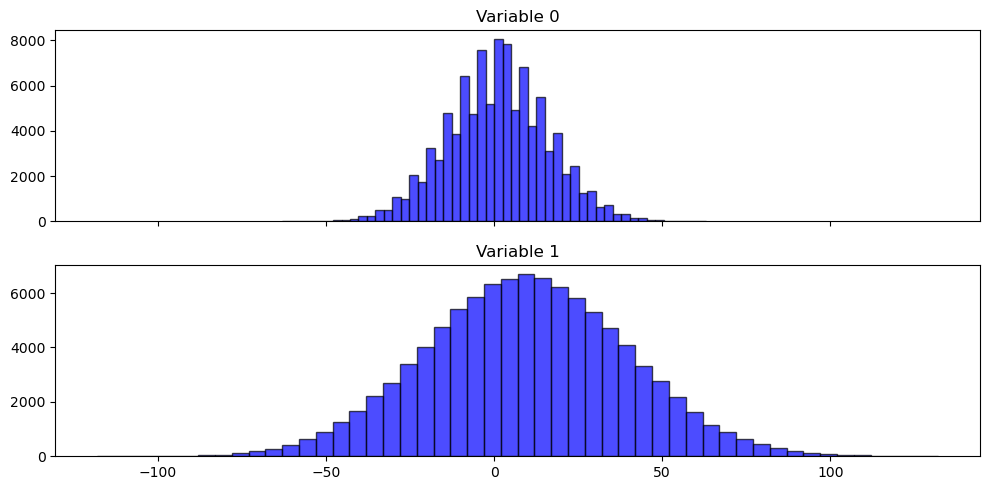

1.0
Window 0 took 0.12639617919921875 seconds
Window 1 took 0.13368701934814453 seconds


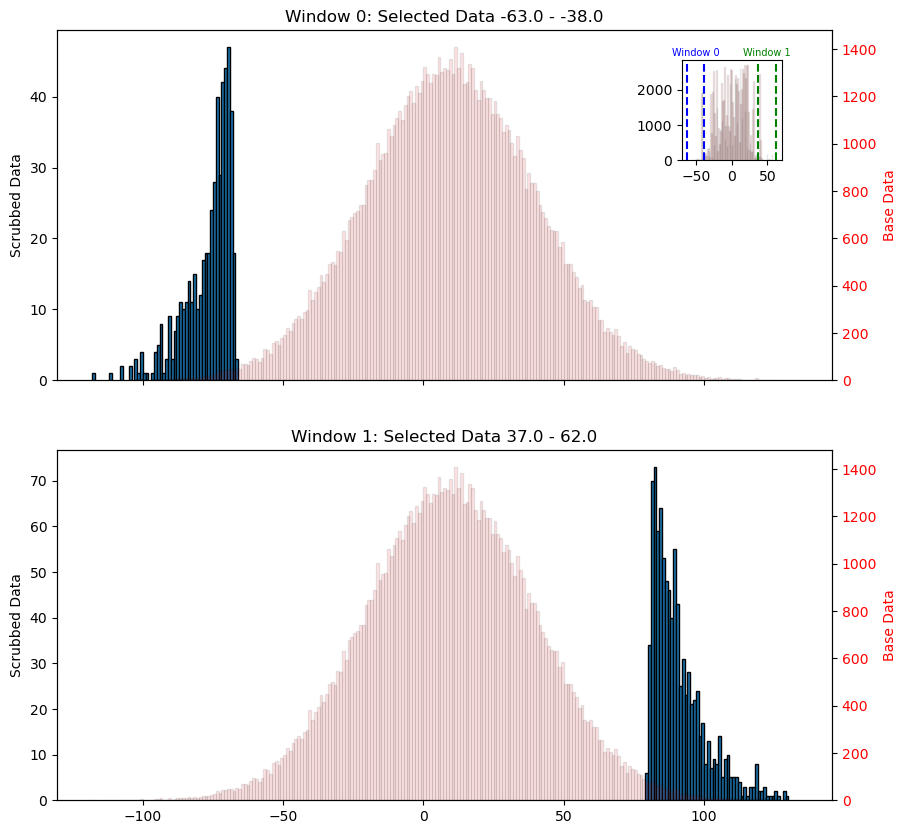

1.0
Window 0 took 0.1251070499420166 seconds
Window 1 took 0.14586496353149414 seconds


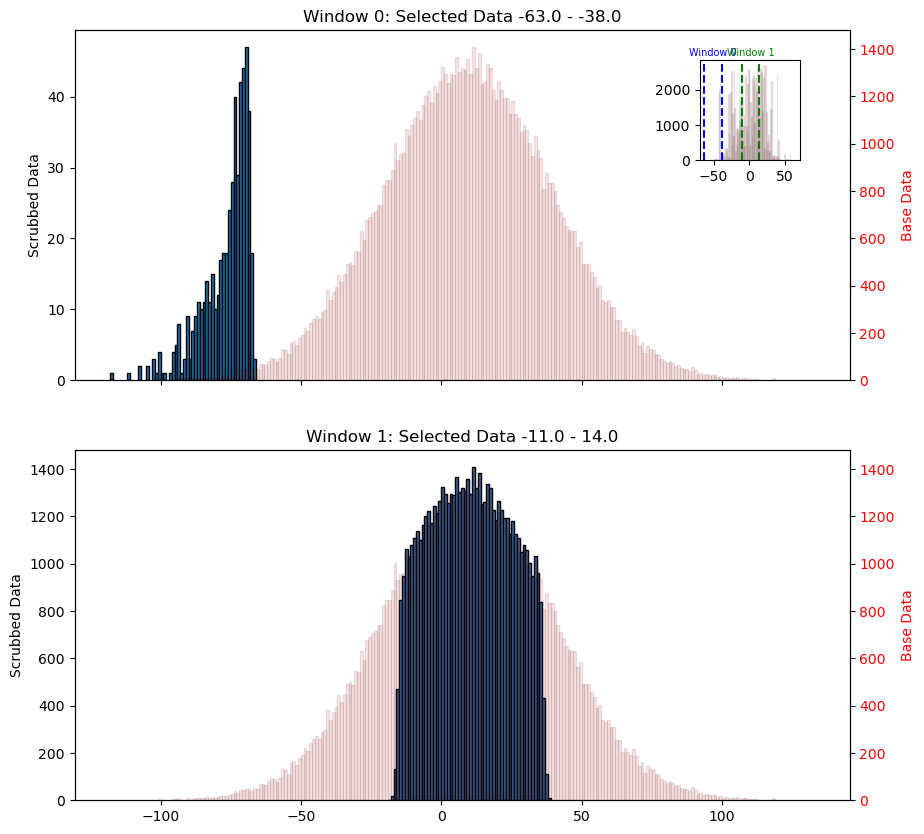

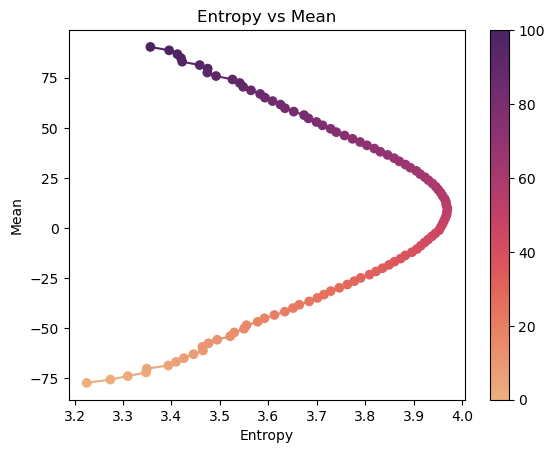

In [29]:
# Define simple causal matrix with two related variables
causal_matrix = np.array([
    [lambda x: np.random.normal(1, 15, size=x), lambda x: 2 * x + 7 ],
    [0, 0]
])

e2e(causal_matrix, 100000, round=0, brush='variable_0', dependent='variable_1')

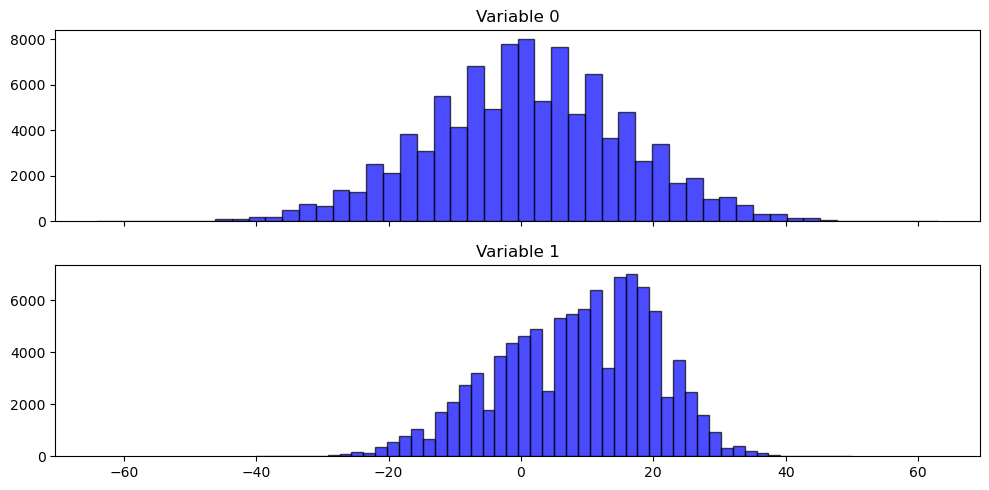

1.0
Window 0 took 0.0683450698852539 seconds
Window 1 took 0.22205686569213867 seconds


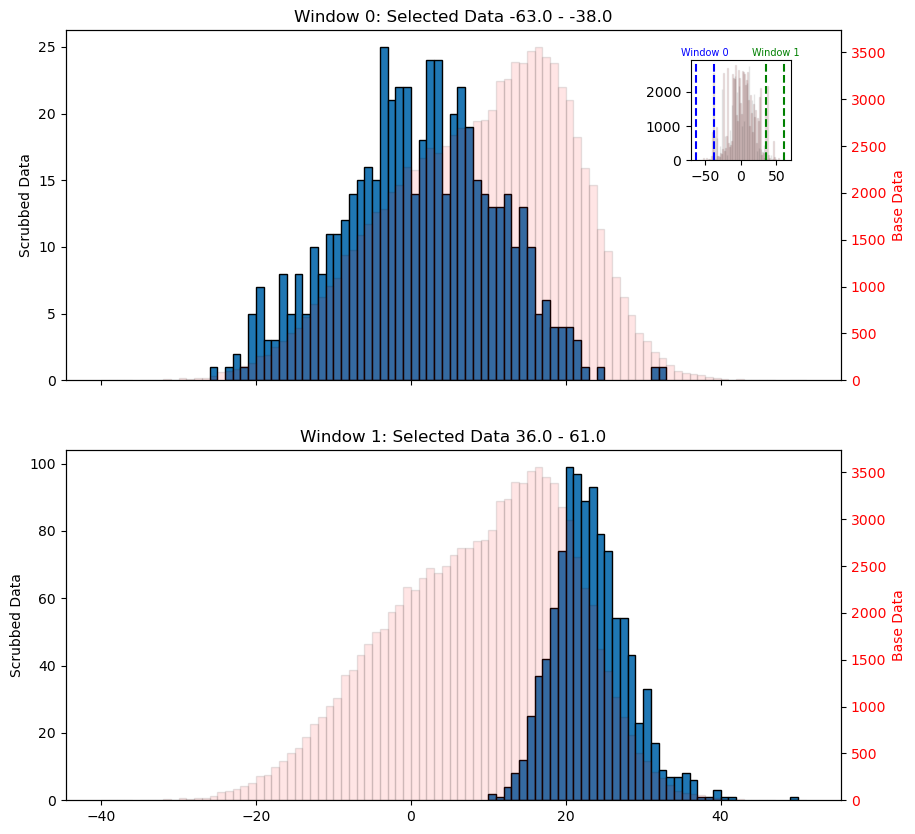

1.0
Window 0 took 0.06608009338378906 seconds
Window 1 took 0.08023500442504883 seconds


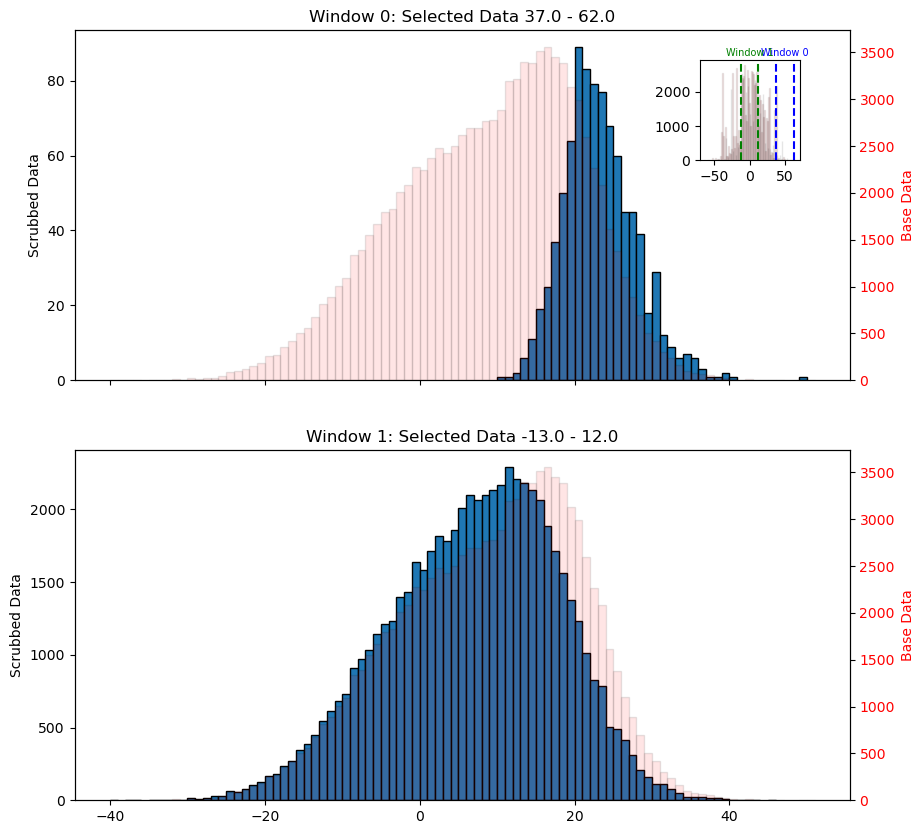

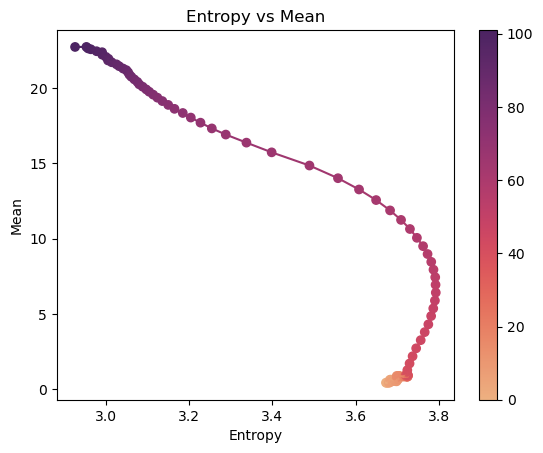

In [27]:
# Define simple causal matrix with two related variables
causal_matrix = np.array([
    [lambda x: np.random.normal(1, 15, size=x), lambda x: np.max(np.random.normal(1, 10, size=max(int(x), 1)))],
    [0, 0]
])

e2e(causal_matrix, 100000, round=0, brush='variable_0', dependent='variable_1')

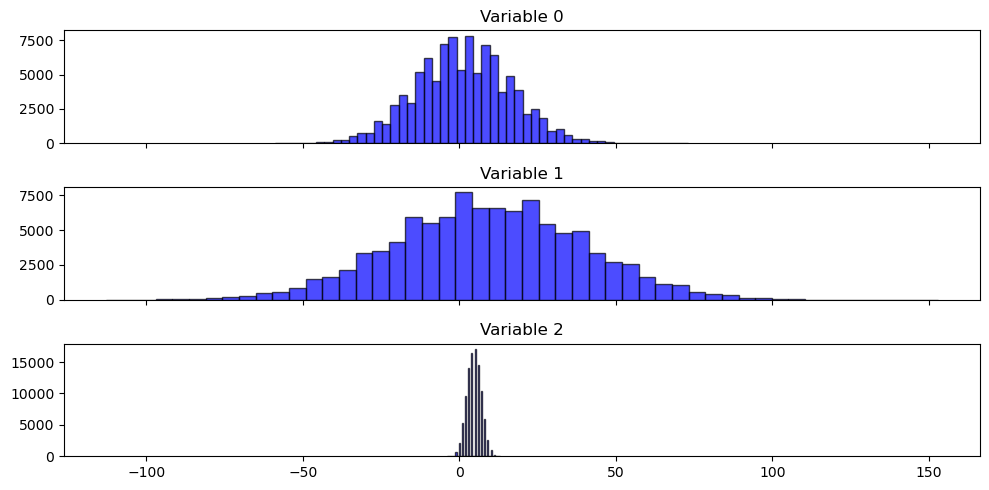

1.0
Window 0 took 0.026098012924194336 seconds
Window 1 took 0.02306199073791504 seconds


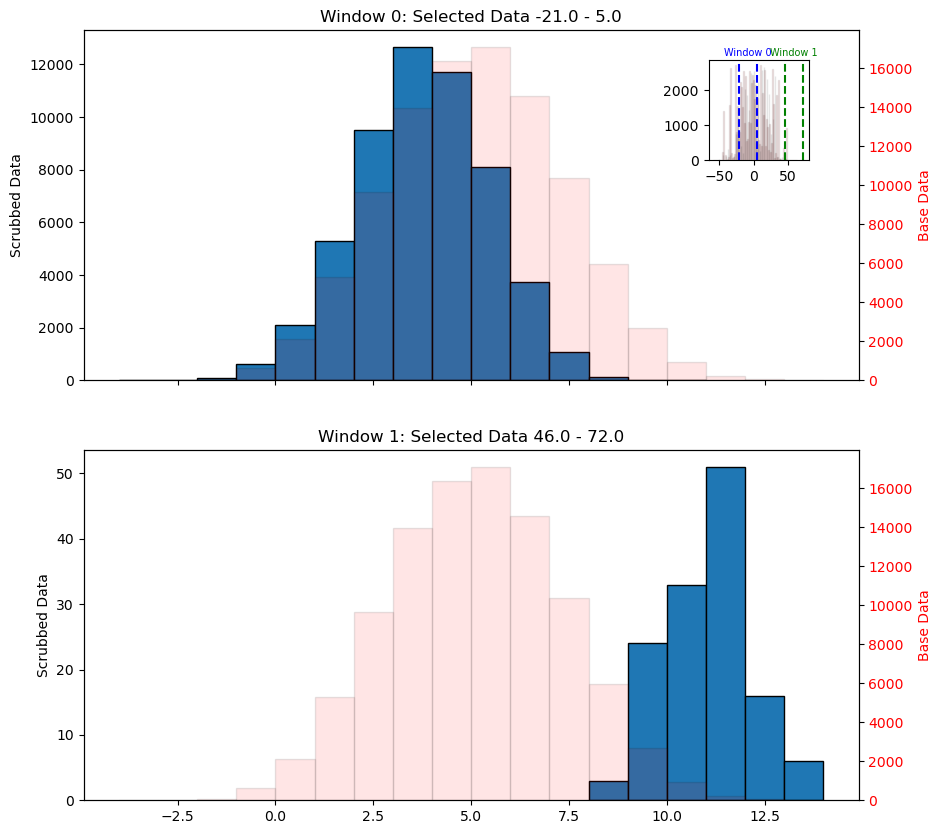

1.0
Window 0 took 0.023101091384887695 seconds
Window 1 took 0.025468111038208008 seconds


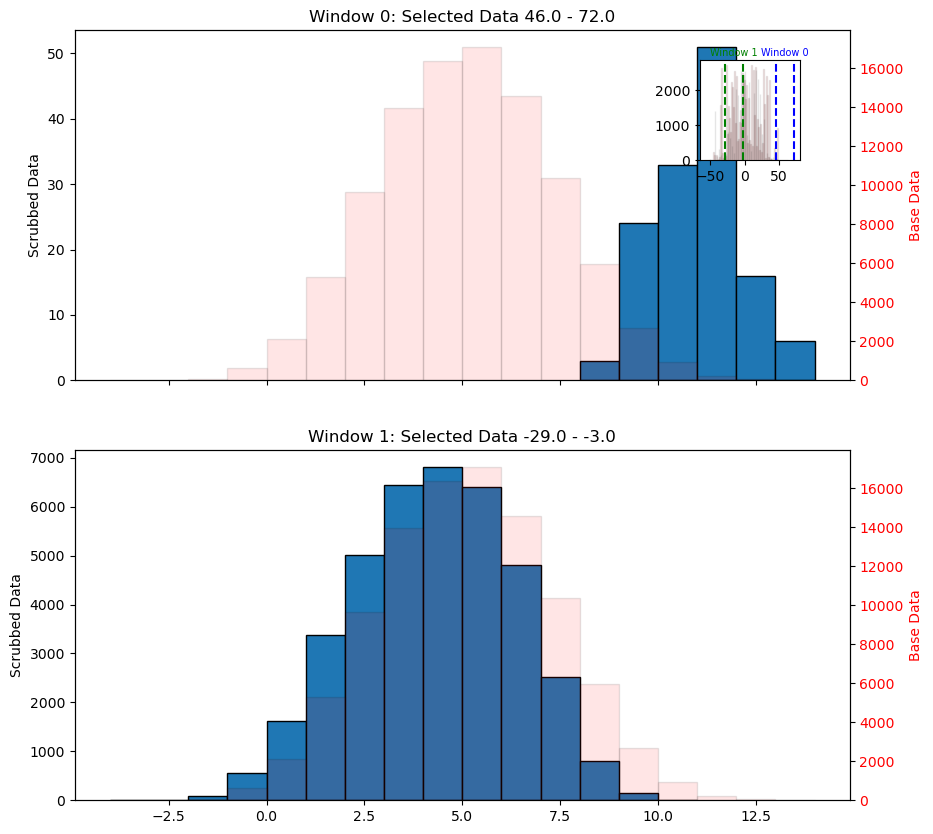

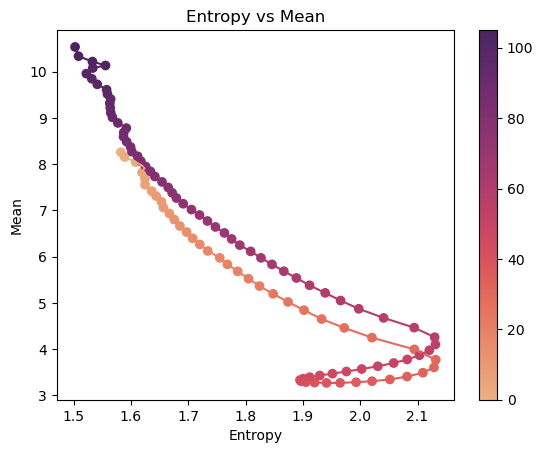

In [31]:
# Define simple causal matrix with two related variables that aren't directly related but are related through a third variable
causal_matrix = np.array([
    [lambda x: np.random.normal(1, 15, size=x), lambda x: 2 * x + 7, 0],
    [0, 0, lambda x: np.abs(x) **0.5],
    [0, 0, 0]
])

e2e(causal_matrix, 100000, round=0, brush='variable_0', dependent='variable_2')

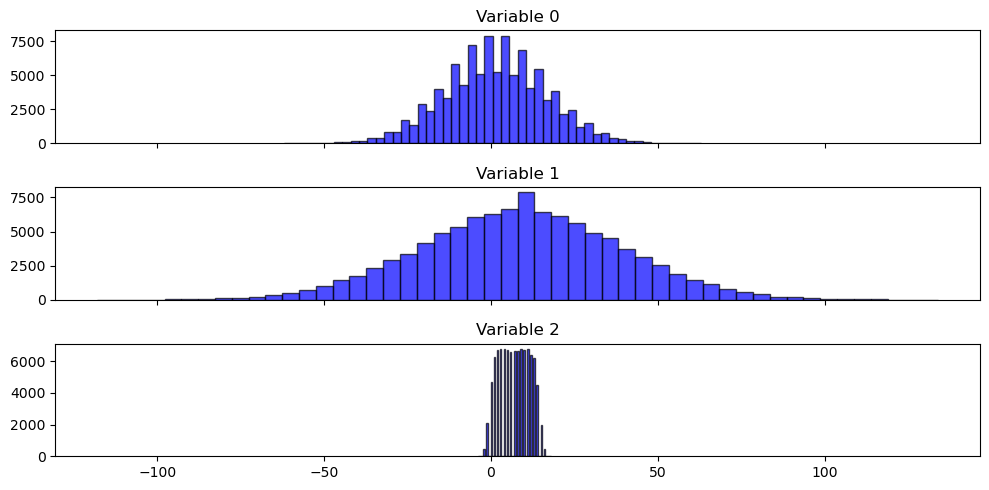

1.0
Window 0 took 0.17869114875793457 seconds
Window 1 took 0.14384794235229492 seconds


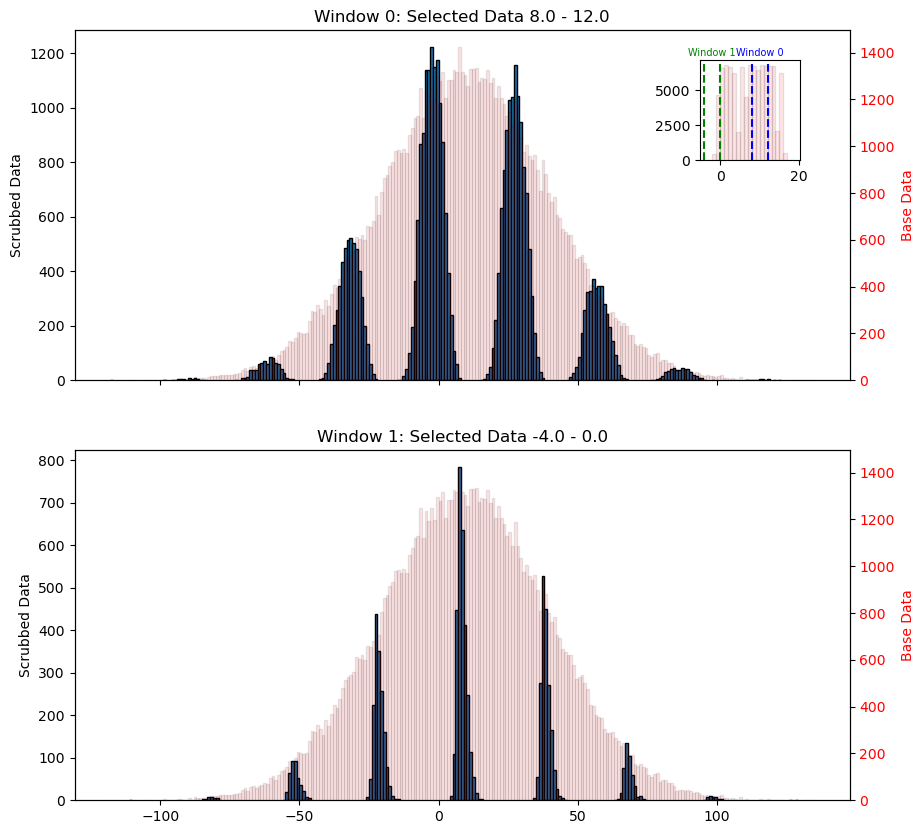

1.0
Window 0 took 0.2803220748901367 seconds
Window 1 took 0.1719040870666504 seconds


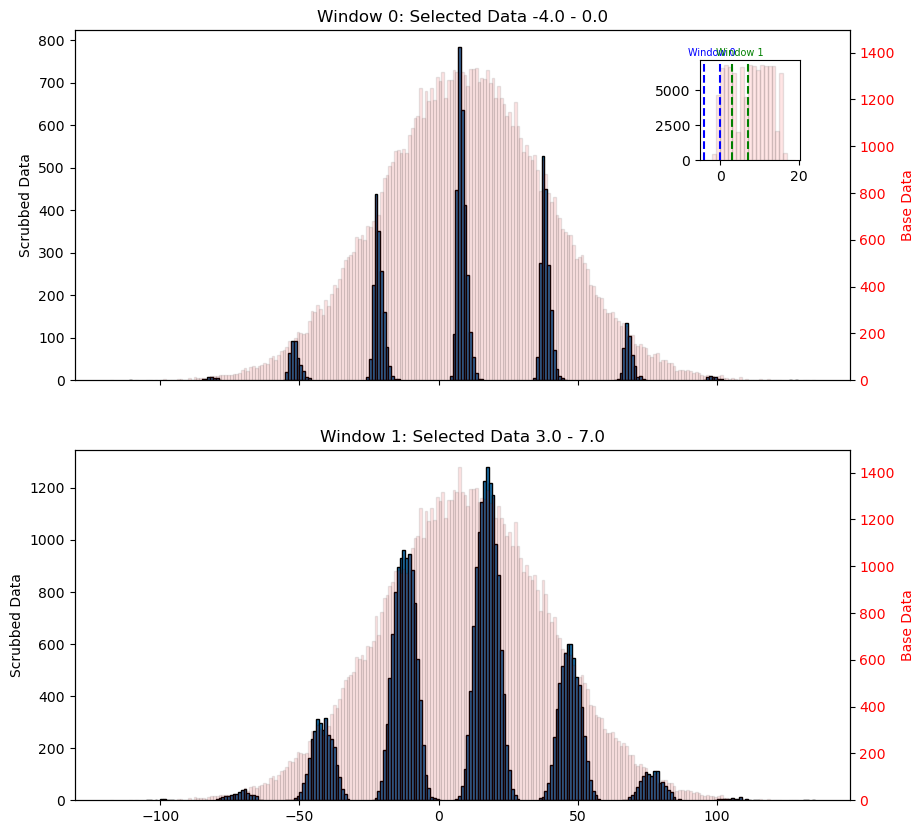

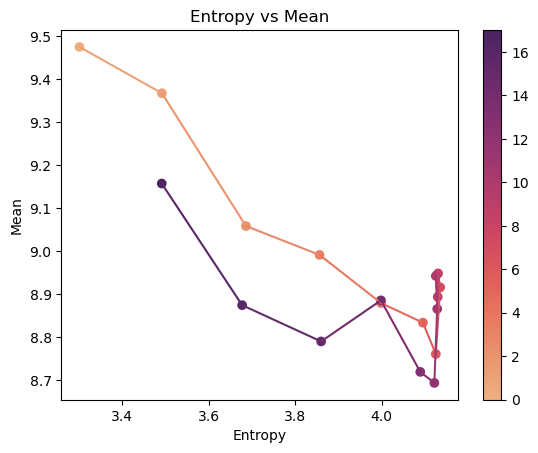

In [37]:
# Define simple causal matrix with two related variables that aren't directly related but are related through a CONFOUNDING third variable
causal_matrix = np.array([
    [lambda x: np.random.normal(1, 15, size=x), lambda x: 2 * x + 7, lambda x: x % 15],
    [0, 0, 0],
    [0, 0, 0]
])

e2e(causal_matrix, 100000, round=0, brush='variable_2', dependent='variable_1')

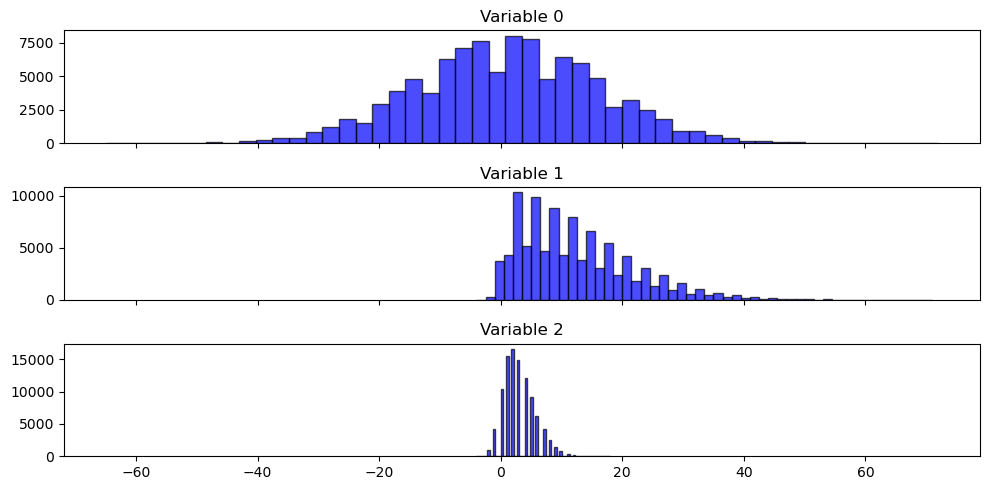

1.0
Window 0 took 0.027591943740844727 seconds
Window 1 took 0.023601770401000977 seconds


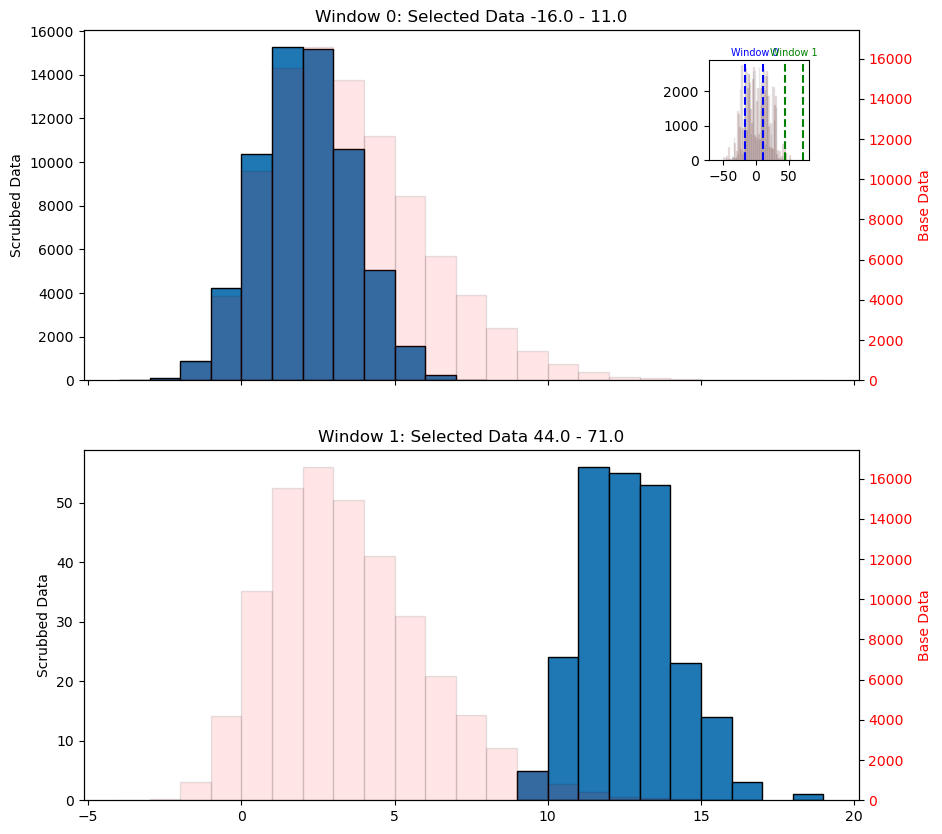

1.0
Window 0 took 0.027009010314941406 seconds
Window 1 took 0.02797985076904297 seconds


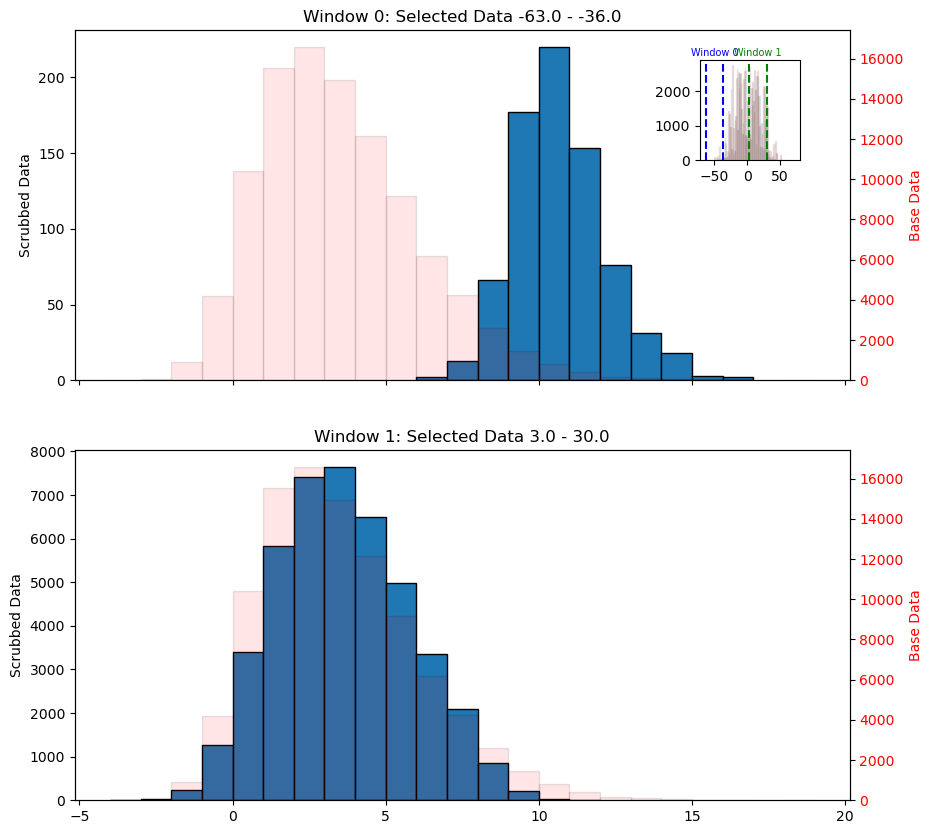

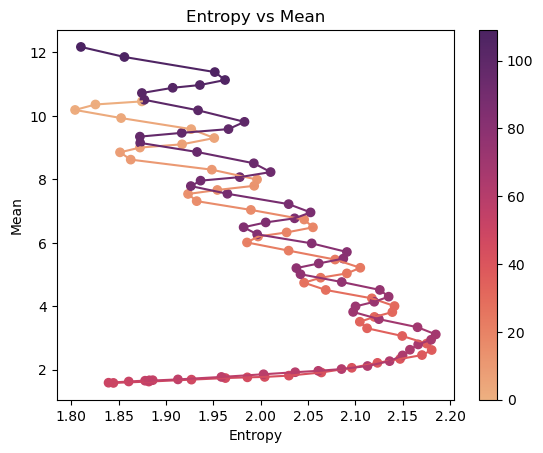

In [54]:
# Define simple causal matrix with two related variables with a Spurious Relationship
causal_matrix = np.array([
    [lambda x: np.random.normal(1, 15, size=x), lambda x: abs(x), lambda x: 0.5 * np.sin(x) + 0.5 * np.cos(x)],
    [0, 0, lambda x: 0.25*x],
    [0, 0, 0]
])

e2e(causal_matrix, 100000, round=0, brush='variable_0', dependent='variable_2')

### Older Exploration

In [201]:
data = pd.DataFrame({'x1': [2, 1, 3, 4, 5], 'x2': [2, 3, 4, 5, 6], 'y': [1, 1, 1, 1, 1]})
assert entropy(data) == 1.6094379124341005, 'Entropy is not correct: {}'.format(entropy(data))
assert mean(data) == 3, 'Mean is not correct: {}'.format(mean(data))
assert median(data) == 3, 'Median is not correct: {}'.format(median(data))
assert sd(data) == 1.4142135623730951, 'Standard deviation is not correct: {}'.format(sd(data))

In [202]:
l1_10 = search_data_cube_window_active0(
    data_cube_delay_time, 'data_cube_delay',
    lambda scrubbed: L1_norm(get_base_data('data_cube_delay'), scrubbed),
    window_size=10,
    strict=False,
    optimization=5
)

plt.figure(figsize=(12, 6))
sns.heatmap(l1_10, cmap='hot')
plt.gca().set_facecolor('gray')
plt.xlabel('End of the window')
plt.ylabel('Start of the window')
plt.title('L1 Norm')
plt.show()

NameError: name 'data_cube_delay_time' is not defined

100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


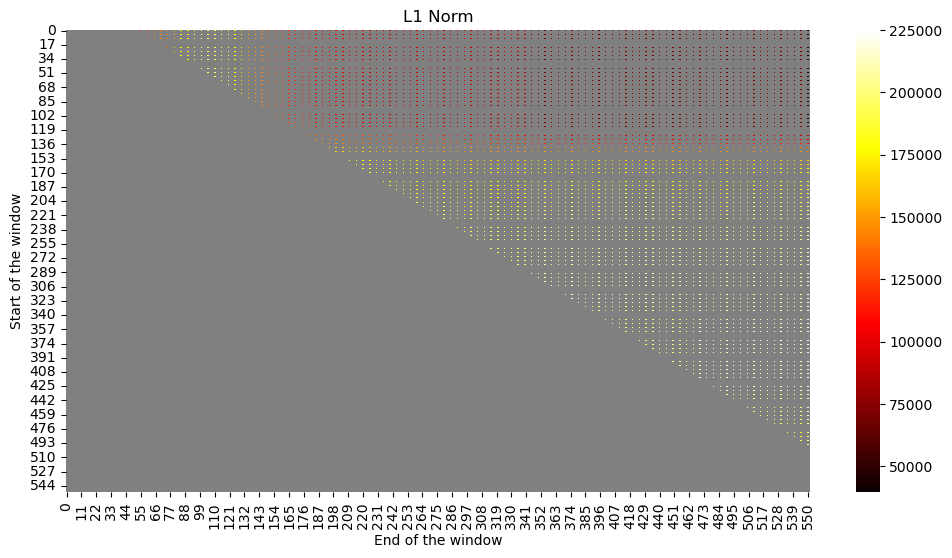

In [ ]:
l1_10 = search_data_cube_window_active0(
    data_cube_delay_time, 'data_cube_delay',
    lambda scrubbed: L1_norm(get_base_data('data_cube_delay'), scrubbed),
    window_size=10,
    strict=False,
    optimization=10
)

plt.figure(figsize=(12, 6))
sns.heatmap(l1_10, cmap='hot')
plt.gca().set_facecolor('gray')
plt.xlabel('End of the window')
plt.ylabel('Start of the window')
plt.title('L1 Norm')
plt.show()

100%|██████████| 249/249 [02:11<00:00,  1.90it/s]


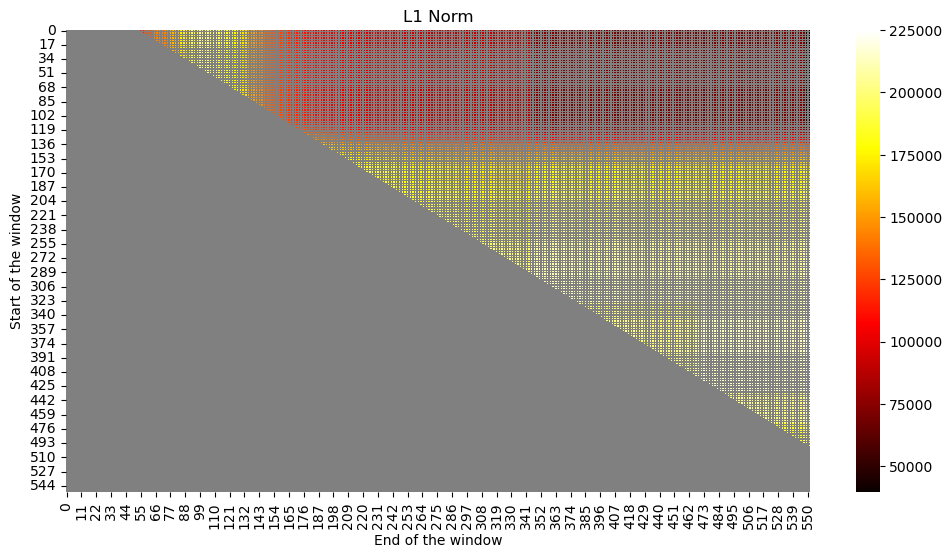

In [ ]:
l1_10 = search_data_cube_window_active0(
    data_cube_delay_time, 'data_cube_delay',
    lambda scrubbed: L1_norm(get_base_data('data_cube_delay'), scrubbed),
    window_size=10,
    strict=False,
    optimization=20
)

plt.figure(figsize=(12, 6))
sns.heatmap(l1_10, cmap='hot')
plt.gca().set_facecolor('gray')
plt.xlabel('End of the window')
plt.ylabel('Start of the window')
plt.title('L1 Norm')
plt.show()

100%|██████████| 497/497 [08:35<00:00,  1.04s/it]


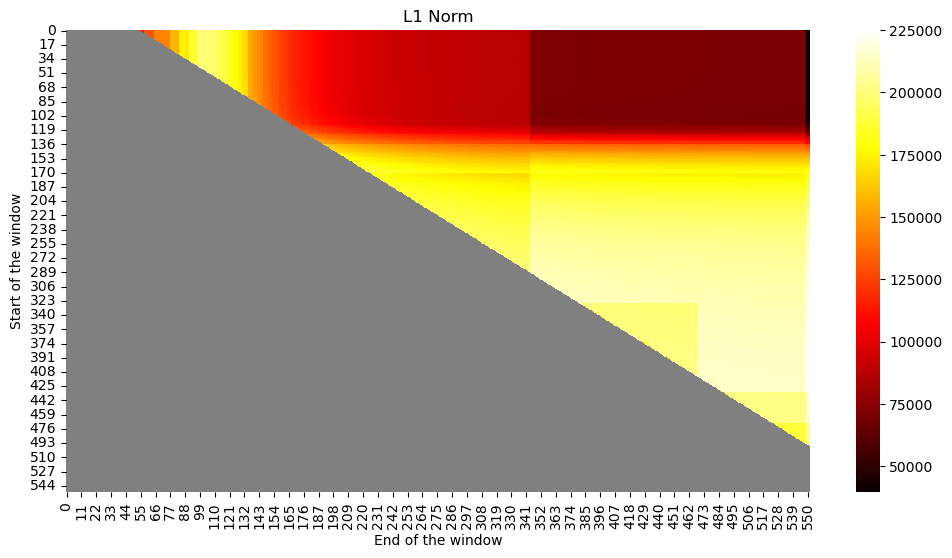

In [ ]:
l1_10 = search_data_cube_window_active0(
    data_cube_delay_time, 'data_cube_delay',
    lambda scrubbed: L1_norm(get_base_data('data_cube_delay'), scrubbed),
    window_size=10,
    strict=False,
)

plt.figure(figsize=(12, 6))
sns.heatmap(l1_10, cmap='hot')
plt.gca().set_facecolor('gray')
plt.xlabel('End of the window')
plt.ylabel('Start of the window')
plt.title('L1 Norm')
plt.show()

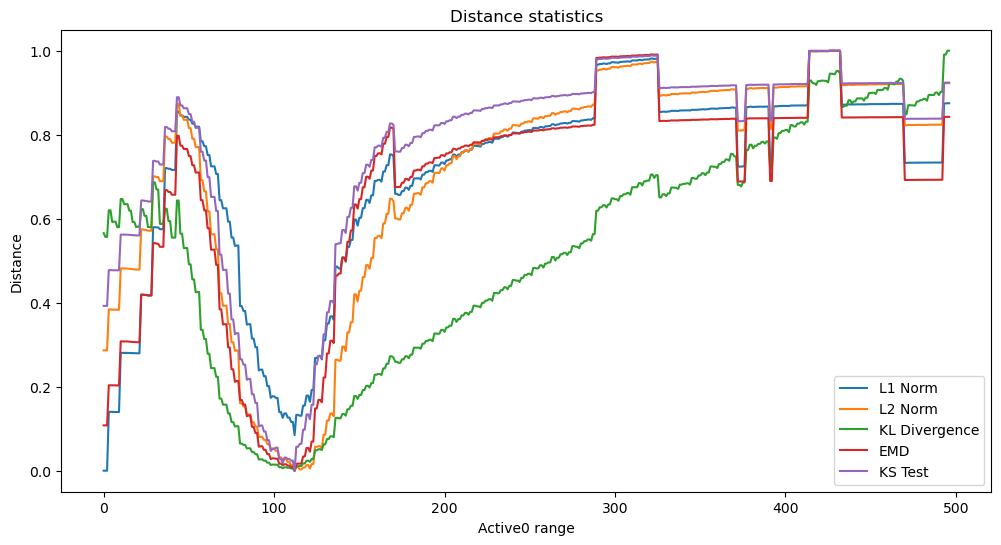

In [ ]:
l1_10 = search_data_cube_window_active0(
    data_cube_delay_time,
    lambda scrubbed: L1_norm(get_base_data(data_cube_delay_time), scrubbed),
    window_size=10
)
l2_10 = search_data_cube_window_active0(
    data_cube_delay_time,
    lambda scrubbed: L2_norm(get_base_data(data_cube_delay_time), scrubbed),
    window_size=10
)
kl_10 = search_data_cube_window_active0(
    data_cube_delay_time,
    lambda scrubbed: KL_divergence(get_base_data(data_cube_delay_time), scrubbed),
    window_size=10
)
emd_10 = search_data_cube_window_active0(
    data_cube_delay_time,
    lambda scrubbed: EMD(get_base_data(data_cube_delay_time), scrubbed),
    window_size=10
)
ks_10 = search_data_cube_window_active0(
    data_cube_delay_time,
    lambda scrubbed: KS_test(get_base_data(data_cube_delay_time), scrubbed),
    window_size=10
)

# Normalize the data for plotting
norm_l1_10 = Normalize()(l1_10)
norm_l2_10 = Normalize()(l2_10)
norm_kl_10 = Normalize()(kl_10)
norm_emd_10 = Normalize()(emd_10)
norm_ks_10 = Normalize()(ks_10)


plt.figure(figsize=(12, 6))
plt.title('Distance statistics')
plt.xlabel('Active0 range')
plt.ylabel('Distance')
plt.plot(norm_l1_10, label='L1 Norm')
plt.plot(norm_l2_10, label='L2 Norm')
plt.plot(norm_kl_10, label='KL Divergence')
plt.plot(norm_emd_10, label='EMD')
plt.plot(norm_ks_10, label='KS Test')
plt.legend()
plt.show()

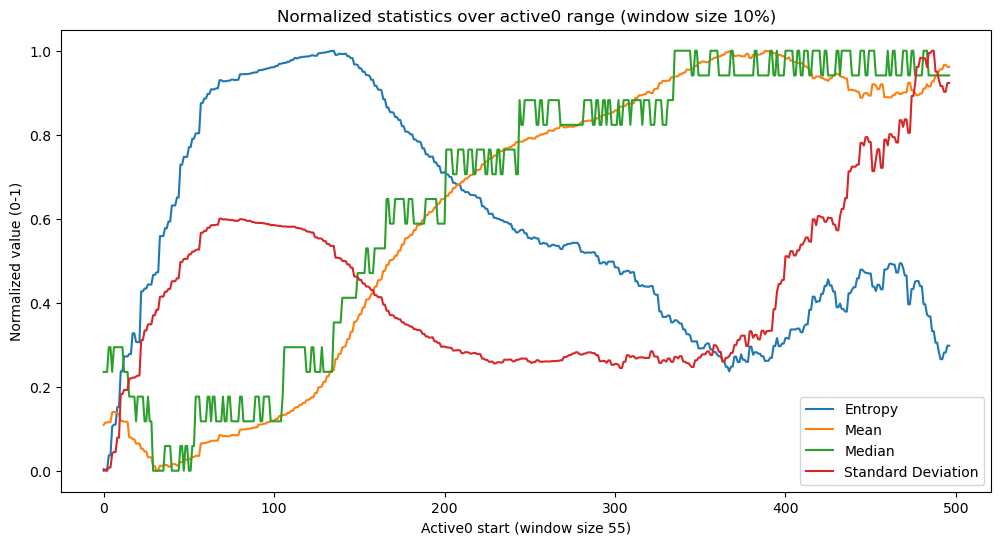

In [ ]:
entropy_10 = search_data_cube_window_active0(data_cube_delay_time, entropy, window_size=10, strict=True)
mean_10 = search_data_cube_window_active0(data_cube_delay_time, mean, window_size=10, strict=True)
median_10 = search_data_cube_window_active0(data_cube_delay_time, median, window_size=10, strict=True)
sd_10 = search_data_cube_window_active0(data_cube_delay_time, sd, window_size=10, strict=True)

# Normalize the data for plotting
norm_entropy_10 = Normalize()(entropy_10)
norm_mean_10 = Normalize()(mean_10)
norm_median_10 = Normalize()(median_10)
norm_sd_10 = Normalize()(sd_10)

# Plot the data
plt.figure(figsize=(12, 6))
plt.title('Normalized statistics over active0 range (window size 10%)')
plt.xlabel('Active0 start (window size 55)')
plt.ylabel('Normalized value (0-1)')
plt.plot(norm_entropy_10, label='Entropy')
plt.plot(norm_mean_10, label='Mean')
plt.plot(norm_median_10, label='Median')
plt.plot(norm_sd_10, label='Standard Deviation')
plt.legend()
plt.show()

In [ ]:
entropy_10 = search_data_cube_window_active0(data_cube_delay_time, 'data_cube_delay', mean, window_size=3, strict=False)
# plot the data as a heatmap
plt.figure(figsize=(12, 6))
plt.title('Mean over active0 range (window size 10%)')
sns.heatmap(entropy_10, cmap='hot')
plt.gca().set_facecolor('gray')
plt.show()

NameError: name 'plt' is not defined

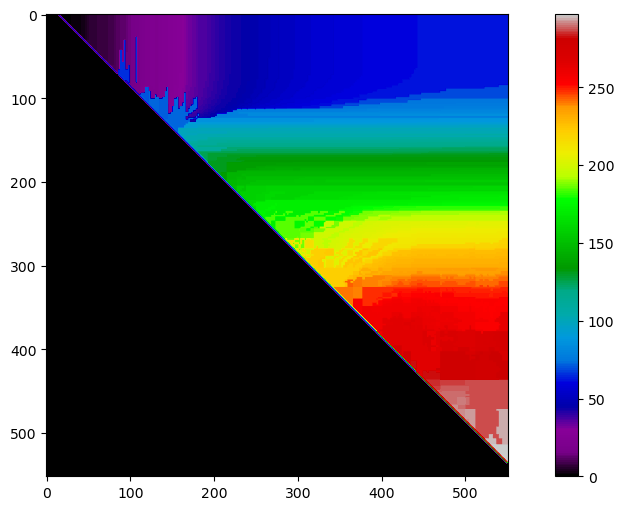

In [ ]:
# run a image segmentation algorithm to find the best segment of the entropy_10 matrix and the mean_10 matrix
import cv2
from skimage.segmentation import felzenszwalb

# convert the multi_d matrix to a 3 channel image
image = np.stack([entropy_10, entropy_10, entropy_10], axis=-1)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = cv2.convertScaleAbs(image)

# run the felzenszwalb algorithm
segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# plot the segmentation
plt.figure(figsize=(12, 6))
plt.imshow(segments_fz, cmap='nipy_spectral')
plt.colorbar()
plt.show()

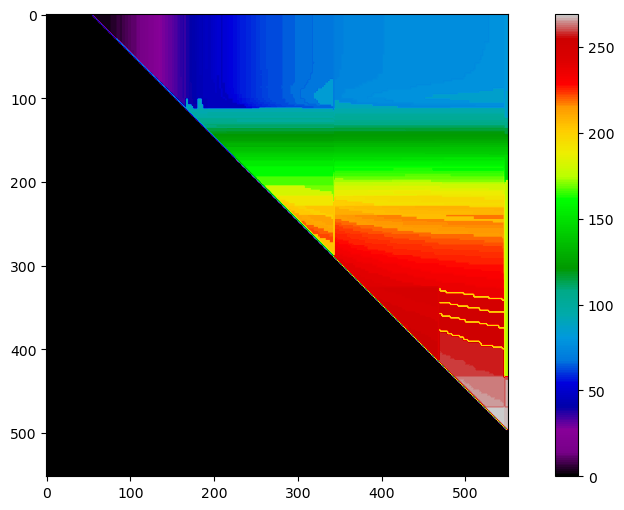

In [ ]:
# run a image segmentation algorithm to find the best segment of the entropy_10 matrix and the l1_10 matrix
import cv2
from skimage.segmentation import felzenszwalb

# convert the multi_d matrix to a 3 channel image
image = np.stack([l1_10, l1_10, l1_10], axis=-1)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = cv2.convertScaleAbs(image)

# run the felzenszwalb algorithm
segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# plot the segmentation
plt.figure(figsize=(12, 6))
plt.imshow(segments_fz, cmap='nipy_spectral')
plt.colorbar()
plt.show()

### V1 - Even Older Exploration

In [ ]:
# HELPERS
def get_scrubbed_data(data_cube_name, L, R):
    scrub_query = f'SELECT "x1", "x2", SUM("y")::DOUBLE AS "y" FROM "{data_cube_name}" WHERE ("active0" BETWEEN FLOOR(2.32::DOUBLE * ({L} - -60::DOUBLE))::INTEGER AND FLOOR(2.32::DOUBLE * ({R} - -60::DOUBLE))::INTEGER) GROUP BY "x1", "x2" ORDER BY "x1", "x2"'
    scrubbed_vals = duckdb.query(scrub_query).df()
    return scrubbed_vals

def show_histogram(data):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='x1', y='y', data=data, width=0.98, color='blue', saturation=0.5)
    return plt.show()

In [ ]:
'''
    Find selected ranges that are maximually different from the base histograms (time and delay)
    using the backing data and its differences. Use the passed in metric to determin difference
    between the data backing the histograms. Return the values for the left and right bounds of
    the selected range that maximizes the difference.

    Args:
    - data_cube_name: The name of the data cube to use. Should be either 'data_cube_delay' or 'data_cube_time'.
                      in order to find the backing data for the base histogram (no selection), you can call
                      get_scrubbed_data with the min and max values of the delay or time columns.
    - difference_metric: A function that takes in two dataframes and returns a scalar value.

    Returns:
        - L: The left bound of the selected range that maximizes the difference
            (smallest active0 value in the resulting histogram)
        - R: The right bound of the selected range that maximizes the difference
            (largest active0 value in the resulting histogram)
'''
def find_selected_range(data_cube_name, difference_metric):
    # Store the values at each selection in a 2d matrix
    diffs = np.zeros((df['delay'].max() - df['delay'].min(), df['delay'].max() - df['delay'].min()))

    # Get the base histograms
    base_data = get_scrubbed_data(data_cube_name, df['delay'].min(), df['delay'].max())

    # Find the selected range that maximizes the difference
    max_diff = 0
    L = None
    R = None
    for i in range(df['delay'].min(), df['delay'].max()):
        for j in range(i, df['delay'].max()):
            scrubbed_vals = get_scrubbed_data(data_cube_name, i, j)
            diff = difference_metric(base_data, scrubbed_vals)
            diffs[i - df['delay'].min(), j - df['delay'].min()] = diff
            if diff > max_diff:
                max_diff = diff
                L = i 
                R = j

    print(f"Max difference: {max_diff} for L: {L} and R: {R}")
    return L, R, diffs

# show_histogram(get_scrubbed_data('data_cube_delay', *find_selected_range('data_cube_delay', L1_norm)))
# show_histogram(get_scrubbed_data('data_cube_delay', *find_selected_range('data_cube_delay', L2_norm)))
# show_histogram(get_scrubbed_data('data_cube_delay', *find_selected_range('data_cube_delay', KL_divergence)))
# show_histogram(get_scrubbed_data('data_cube_delay', *find_selected_range('data_cube_delay', EMD)))
# show_histogram(get_scrubbed_data('data_cube_delay', *find_selected_range('data_cube_delay', KS_test)))

In [ ]:
def find_selected_range_sliding_window(data_cube_name, difference_metric, window_percent=None):
    if window_percent is None: # Default to 10% of the range
        window_percent = 0.1
    window_size = int((df['delay'].max() - df['delay'].min()) * window_percent)

    # Store the values at each selection in a list
    diffs = np.zeros(df['delay'].max() - df['delay'].min() - window_size)

    # Get the base histograms
    base_data = get_scrubbed_data(data_cube_name, df['delay'].min(), df['delay'].max())

    # Find the selected range that maximizes the difference by sliding the window across the range and comparing
    max_diff = 0
    L = None
    R = None
    for i in range(df['delay'].min(), df['delay'].max() - window_size):
        scrubbed_vals = get_scrubbed_data(data_cube_name, i, i + window_size)
        diff = difference_metric(base_data, scrubbed_vals)
        diffs[i - df['delay'].min()] = diff
        if diff > max_diff:
            max_diff = diff
            L = i 
            R = i + window_size

    print(f"Max difference: {max_diff} for L: {L} and R: {R}")
    return L, R, diffs

Max difference: 225040.0 for L: 128 and R: 178


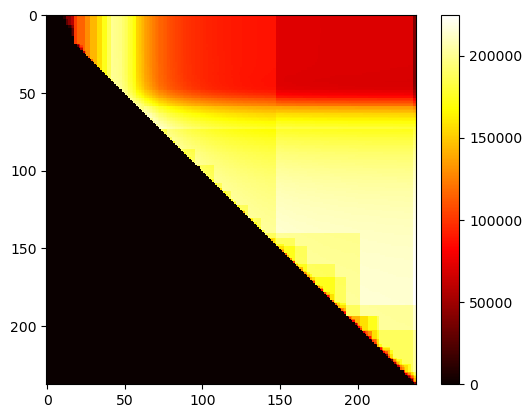

In [ ]:
L, R, diffs = find_selected_range('data_cube_delay', L1_norm)
plt.imshow(diffs, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show() 

Max difference: 214871.0 for L: 128 and R: 151
Max difference: 3086211197.0 for L: 128 and R: 151
Max difference: 1334652.6164165698 for L: 156 and R: 179
Max difference: 1729348.0 for L: 128 and R: 151
Max difference: 214871.0 for L: 128 and R: 151


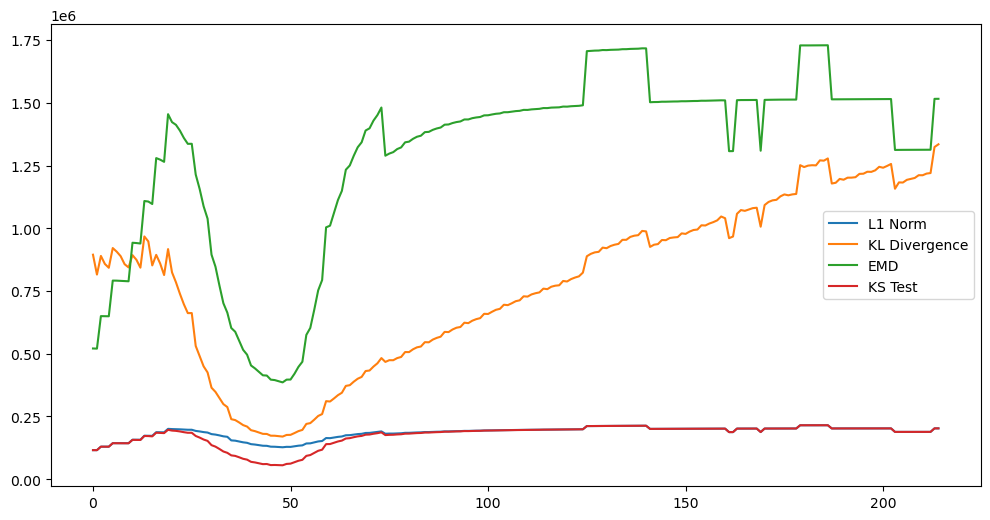

In [ ]:
L, R, diff_l1 = find_selected_range_sliding_window('data_cube_delay', L1_norm, window_percent=0.1)
L, R, diff_l2 = find_selected_range_sliding_window('data_cube_delay', L2_norm, window_percent=0.1)
L, R, diff_kl = find_selected_range_sliding_window('data_cube_delay', KL_divergence, window_percent=0.1)
L, R, diff_emd = find_selected_range_sliding_window('data_cube_delay', EMD, window_percent=0.1)
L, R, diff_ks = find_selected_range_sliding_window('data_cube_delay', KS_test, window_percent=0.1)
# Plot the differences on one graph and different y-axes for each metric so they have their own scale
plt.figure(figsize=(12, 6))
plt.plot(diff_l1, label='L1 Norm')
# plt.plot(diff_l2, label='L2 Norm')
plt.plot(diff_kl, label='KL Divergence')
plt.plot(diff_emd, label='EMD')
plt.plot(diff_ks, label='KS Test')
plt.legend()
plt.show()

Max difference: 211111.0 for L: 15 and R: 17
Max difference: 208375.0 for L: 15 and R: 19
Max difference: 203937.0 for L: 15 and R: 22
Max difference: 214349.0 for L: 82 and R: 91
Max difference: 214141.0 for L: 81 and R: 92
Max difference: 213797.0 for L: 82 and R: 96
Max difference: 215062.0 for L: 128 and R: 144
Max difference: 214961.0 for L: 128 and R: 147
Max difference: 214915.0 for L: 128 and R: 149
Max difference: 214871.0 for L: 128 and R: 151
Max difference: 214822.0 for L: 128 and R: 154
Max difference: 214777.0 for L: 128 and R: 156
Max difference: 214728.0 for L: 128 and R: 158
Max difference: 214672.0 for L: 128 and R: 161
Max difference: 214925.0 for L: 144 and R: 179
Max difference: 214855.0 for L: 141 and R: 179
Max difference: 214780.0 for L: 139 and R: 179
Max difference: 214723.0 for L: 137 and R: 179
Max difference: 214618.0 for L: 134 and R: 179
Max difference: 214554.0 for L: 132 and R: 179
Max difference: 214464.0 for L: 130 and R: 179
Max difference: 225003.0 

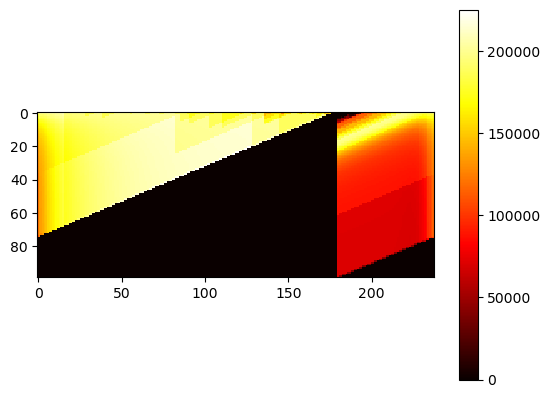

In [ ]:
diffs = np.zeros((99, df['delay'].max() - df['delay'].min()))
for i in range(1, 100):
    L, R, diff = find_selected_range_sliding_window('data_cube_delay', L1_norm, window_percent=i/100)
    diffs[i-1] = diff

plt.imshow(diffs, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()


#### Computer Vision approach

In [ ]:
multi_d = df.groupby([pd.cut(df['time'], bins=50), pd.cut(df['delay'], bins=50)]).size().unstack().to_numpy()
# get the array that represents what time/delay values each bin corresponds to by index
time_bins = pd.cut(df['time'], bins=50).unique().categories.mid.to_numpy()
delay_bins = pd.cut(df['delay'], bins=50).unique().categories.mid.to_numpy()

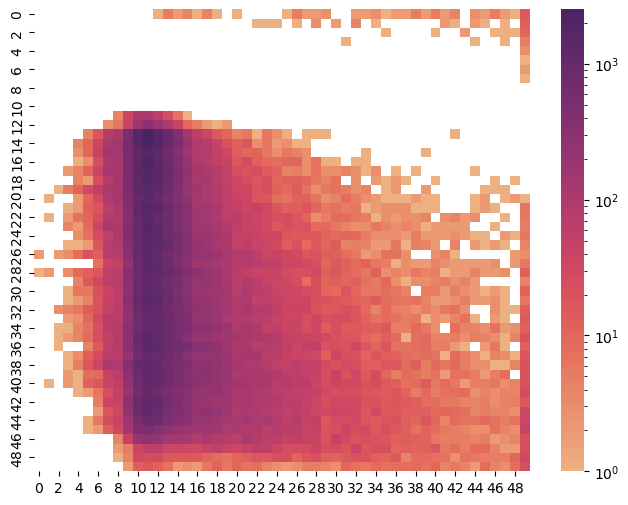

In [ ]:
# Do above but with mutli_d
plt.figure(figsize=(8, 6))
sns.heatmap(multi_d, cmap=sns.color_palette("flare", as_cmap=True), norm=LogNorm())
plt.show()

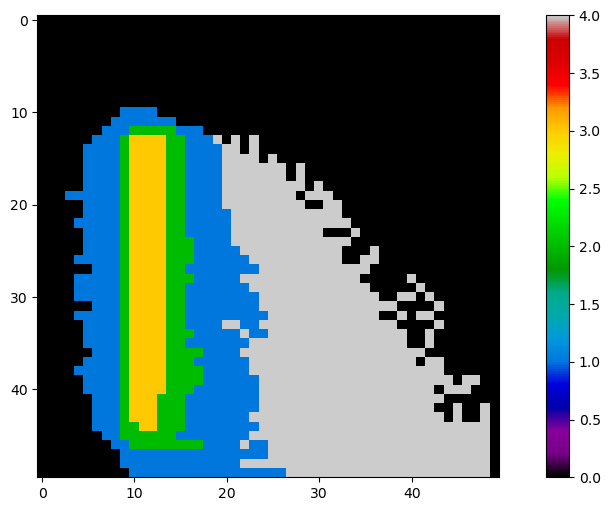

In [ ]:
# run a image segmentation algorithm to find the best segment of the multi_d matrix
import cv2
from skimage.segmentation import felzenszwalb
from skimage.color import rgb2gray

# convert the multi_d matrix to a 3 channel image
image = np.stack([multi_d, multi_d, multi_d], axis=-1)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = cv2.convertScaleAbs(image)

# run the felzenszwalb algorithm
segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)

# plot the segmentation
plt.figure(figsize=(12, 6))
plt.imshow(segments_fz, cmap='nipy_spectral')
plt.colorbar()
plt.show()

Segment 0: 0.24435 to 23.7435
Segment 1: 5.0495 to 23.7435
Segment 2: 6.0085 to 22.305500000000002
Segment 3: 6.487500000000001 to 21.347
Segment 4: 6.487500000000001 to 23.7435
--------------------------------------------------
Segment 0: -55.739000000000004 to 177.62
Segment 1: -41.34 to 68.14
Segment 2: -12.780000000000001 to 25.3
Segment 3: -8.02 to 6.26
Segment 4: 34.82 to 172.86


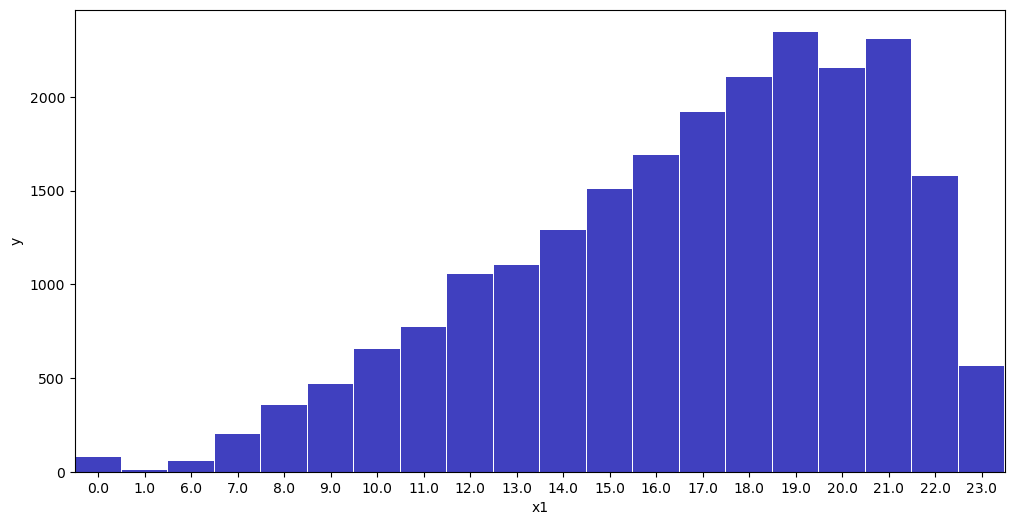

In [ ]:
# get the highest and lowest index (along the 0th axis) of each segment
segment_ranges = {}
for i in range(segments_fz.max() + 1):
    segment_ranges[i] = (np.where(segments_fz == i)[0].min(), np.where(segments_fz == i)[0].max())

# get the time ranges associated with those indices for each segment
segment_time_ranges = {}
for i, (start, end) in segment_ranges.items():
    segment_time_ranges[i] = (time_bins[start], time_bins[end])

# get the highest and lowest index (along the 1st axis) of each segment
segment_ranges = {}
for i in range(segments_fz.max() + 1):
    segment_ranges[i] = (np.where(segments_fz == i)[1].min(), np.where(segments_fz == i)[1].max())

# get the delay ranges associated with those indices for each segment
segment_delay_ranges = {}
for i, (start, end) in segment_ranges.items():
    segment_delay_ranges[i] = (delay_bins[start], delay_bins[end])

# print the time ranges for each segment
for i, (start, end) in segment_time_ranges.items():
    print(f"Segment {i}: {start} to {end}")

print('-' * 50)

# print the delay ranges for each segment
for i, (start, end) in segment_delay_ranges.items():
    print(f"Segment {i}: {start} to {end}")

# show_histogram(get_scrubbed_data('data_cube_delay', *segment_delay_ranges[0]))
# show_histogram(get_scrubbed_data('data_cube_delay', *segment_delay_ranges[1]))
# show_histogram(get_scrubbed_data('data_cube_delay', *segment_delay_ranges[2]))
# show_histogram(get_scrubbed_data('data_cube_delay', *segment_delay_ranges[3]))
show_histogram(get_scrubbed_data('data_cube_delay', *segment_delay_ranges[4]))
# show_histogram(get_scrubbed_data('data_cube_time', *segment_time_ranges[0]))
# show_histogram(get_scrubbed_data('data_cube_time', *segment_time_ranges[1]))
# show_histogram(get_scrubbed_data('data_cube_time', *segment_time_ranges[2]))
# show_histogram(get_scrubbed_data('data_cube_time', *segment_time_ranges[3]))
# show_histogram(get_scrubbed_data('data_cube_time', *segment_time_ranges[4]))

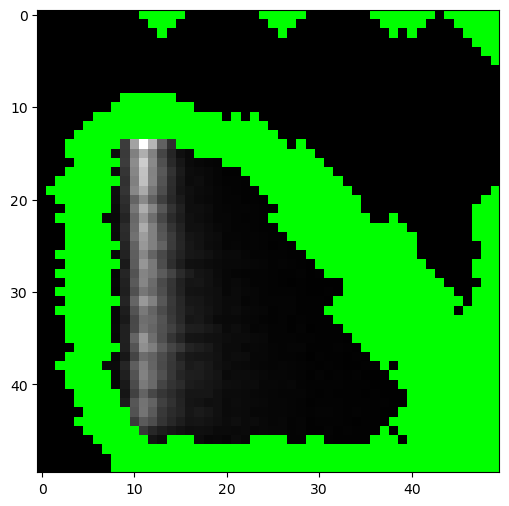

In [ ]:
# Run and plot rectangle detection on the multi_d matrix using the cv2.findContours function
# convert the multi_d matrix to a 3 channel image
image = np.stack([multi_d, multi_d, multi_d], axis=-1)
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
image = cv2.convertScaleAbs(image)

# convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# find the contours
contours, _ = cv2.findContours(image_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# draw the contours
cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

# plot the contours
plt.figure(figsize=(12, 6))
plt.imshow(image)
plt.show()